<a href="https://colab.research.google.com/github/matroskinsk/Deep_learning/blob/main/museum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h3 style="text-align: center;"><b>Цифровой прорыв 2021</b></h3>

<h3 style="text-align: center;"><b>Задача:
Музейный фонд</b></h3>

<p style="align: center;"><img align=center src="https://media-exp3.licdn.com/dms/image/C561BAQEw7KL3JnRJ9Q/company-background_10000/0/1543513814252?e=2159024400&v=beta&t=MEymCzBizr73SMjRW0HJ-zkx2zMSBhiF2Mxs5GwxTyw" width=600 height=400/></p>





Work performed by Ivan Kochkurov

https://github.com/matroskinsk

#Description of tasks

Необходимо по описанию или изображению определить категорию предмета музейного фонда

#License

MIT License

Copyright (c) 2021 IKochkurov

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

#Introductory Section

##Installing modules

In [ ]:
!pip install logging
!pip install munch
!pip install marshmallow
!pip install pytorch-ignite


     |████████████████████████████████| 96 kB 2.7 MB/s 
ERROR: Could not find a version that satisfies the requirement logging (from versions: 0.4.9.6)
ERROR: No matching distribution found for logging
     |████████████████████████████████| 47 kB 3.0 MB/s 
     |████████████████████████████████| 232 kB 8.3 MB/s 


##Loading Libraries

In [ ]:
from abc import ABC
from marshmallow import Schema, fields, validate
from munch import Munch
from torchvision import transforms, models
import importlib
import os
from time import time
import numpy as np
import tifffile
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import logging
import torch.optim as optim
import collections
from shutil import copyfile
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from ignite.metrics import confusion_matrix
from ignite.metrics.multilabel_confusion_matrix import MultiLabelConfusionMatrix
import matplotlib.pyplot as plt
from pathlib import Path
from copy import copy
from torch.utils.data import Dataset, random_split
from datetime import datetime
from torchvision import transforms as T
import os
from scipy import sparse
from osgeo import gdal, gdal_array
import fastai
import random
import torchvision.transforms.functional as transforms_F
import multiprocessing
import ntpath
import pickle
from sklearn.preprocessing import LabelEncoder

#Loading data

###Google Drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


###Загрузка трейновых данных

In [ ]:
!unzip -u '/content/gdrive/MyDrive/museum/images.zip' -d '/content/gdrive/MyDrive/museum/images'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/gdrive/MyDrive/museum/images/images/336a8f31-ebee-4727-9d13-048d994946c8.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/9d202bd0-c591-433d-9e35-fdfed87d2461.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/c4c5f03a-980e-43d2-ba00-e50c45eb899a.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/8f46ea45-8ffb-42d3-a6ee-14542cf8dbc1.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/1585b2c0-fba2-4f28-974c-ffdc5aead670.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/__MACOSX/images/._1585b2c0-fba2-4f28-974c-ffdc5aead670.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/da587001-77f2-4b43-b2d8-7ac64fb8d9fb.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/74e9e57b-f0ad-4d82-b380-74fcf52a6ea9.jpg  
  inflating: /content/gdrive/MyDrive/museum/images/images/fa4455be-bddd-480c-b8ab-fa830dfa2356.jpg  
  inflating:

In [ ]:
!ls /content/gdrive/MyDrive/museum # Посмотрим на структуру папки с данными

00000001.jpg		     my_submission_12.csv   my_submission_8.csv
images			     my_submission_1.csv    my_submission_9.csv
images.zip		     my_submission_2.csv    my_submission.csv
model_resnet_34_30_256.pth   my_submission_3.csv    sample_submission.csv
model_resnet_34_50_256.pth   my_submission_4_1.csv  test.csv
model_resnet_34_50ep_70.pth  my_submission_4.csv    train.csv
model_resnet_34_50ep.pth     my_submission_5.csv    train_url_only.csv
model_resnet_34.pth	     my_submission_6.csv
my_submission_11.csv	     my_submission_7.csv


###Сборка сортировка датасета

In [ ]:
#Подгружаем csv со списками данных
import pandas as pd
list_train_files = pd.read_csv("/content/gdrive/MyDrive/museum/train.csv")
list_test_files = pd.read_csv("/content/gdrive/MyDrive/museum/test.csv")
list_test_sub = pd.read_csv("/content/gdrive/MyDrive/museum/sample_submission.csv")
train_url_only = pd.read_csv("/content/gdrive/MyDrive/museum/train_url_only.csv")


In [ ]:
train_url_only.guid[1]

'43854438-31d8-4551-b3bb-73d44c02dc95'

In [ ]:
import urllib
f = open('/content/gdrive/MyDrive/museum/00000001.jpg','wb')
f.write(urllib.urlopen('train_url_only.url[1]').read())
f.close()

AttributeError: ignored

In [ ]:
url = http://goskatalog.ru/muzfo-imaginator/rest/images/original/1284625/43854438-31d8-4551-b3bb-73d44c02dc95.jpg

In [ ]:
import urllib.request
urllib.request.urlretrieve("http://goskatalog.ru/muzfo-imaginator/rest/images/original/1284625/43854438-31d8-4551-b3bb-73d44c02dc95.jpg", "/content/gdrive/MyDrive/museum/43854438-31d8-4551-b3bb-73d44c02dc95.jpg")

ValueError: ignored

In [ ]:
dir_files = Path('/content/gdrive/MyDrive/museum/images/images/')
all_files = sorted(list(dir_files.rglob('*.jpg')))

In [ ]:
dir_url = Path(f'{train_url_only.url[1]}')
_files = list(dir_url.rglob('*.jpg'))

In [ ]:
_files[0]

IndexError: ignored

In [ ]:
#Файлы с нулевым размером
zero_f = []
for i in range(len(all_files)):
  name_files = ntpath.basename(all_files[i]).split('.')[0]
  b = os.path.getsize(f'/content/gdrive/MyDrive/museum/images/images/{name_files}.jpg')
  if b == 0:
    zero_f.append(name_files)

In [ ]:
len(zero_f)

129

In [ ]:
#Тренировочные файлы для формирования датасета + labels
train_files = []
train_files_labels = []
for i in range(len(list_train_files)):
  for j in range(len(all_files)):
    if list_train_files.guid[i] == ntpath.basename(all_files[j]).split('.')[0] and list_train_files.guid[i] not in zero_f:
       train_files.append(all_files[j])
       train_files_labels.append(list_train_files.typology[i])

In [ ]:
print(len(train_files), len(train_files_labels))
print(train_files_labels[123])

4348 4348
прочие


In [ ]:
with open('/content/gdrive/MyDrive/museum/images/train_files.txt', 'w') as output:
    output.write(str(train_files))
with open('/content/gdrive/MyDrive/museum/images/train_files_labels.txt', 'w') as output:
    output.write(str(train_files_labels))    

In [ ]:
#Загрузка из файла
file_e = [i for i in open('/content/gdrive/MyDrive/museum/images/train_files.txt')]
labels_e = [i for i in open('/content/gdrive/MyDrive/museum/images/train_files_labels.txt')]

###Проверка загрузки

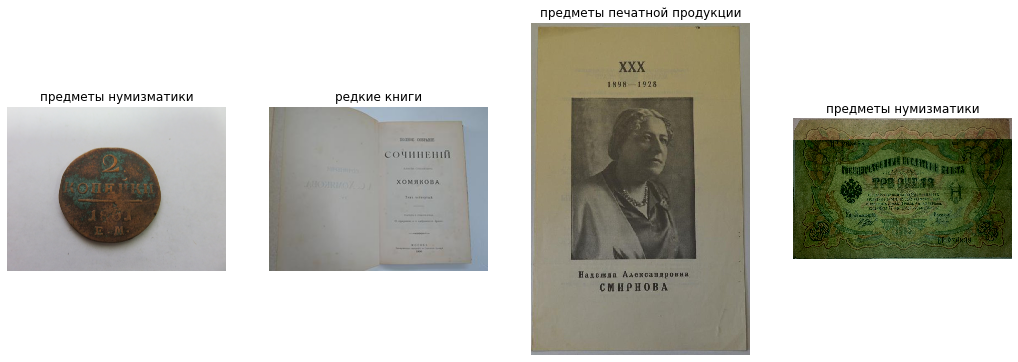

In [ ]:
num = [random.randint(0, len(train_files)) for _ in range(4)]
#Имена файлов из списка трейн файлов
name_files_1 = ntpath.basename(train_files[num[0]]).split('.')[0]
name_files_2 = ntpath.basename(train_files[num[1]]).split('.')[0]
name_files_3 = ntpath.basename(train_files[num[2]]).split('.')[0]
name_files_4 = ntpath.basename(train_files[num[3]]).split('.')[0]
example_image = Image.open(f'/content/gdrive/MyDrive/museum/images/images/{name_files_1}.jpg')
example_image1 = Image.open(f'/content/gdrive/MyDrive/museum/images/images/{name_files_2}.jpg')
example_image2 = Image.open(f'/content/gdrive/MyDrive/museum/images/images/{name_files_3}.jpg')
example_image3 = Image.open(f'/content/gdrive/MyDrive/museum/images/images/{name_files_4}.jpg')
plt.rcParams["figure.figsize"] = (18, 9) # (w, h)
plt.subplot(1,4,1)
plt.imshow(example_image)
plt.title(f"{train_files_labels[num[0]]}")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(example_image1, cmap='gray')
plt.title(f"{train_files_labels[num[1]]}")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(example_image2, cmap='Greys',  interpolation='nearest')
plt.title(f"{train_files_labels[num[2]]}")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(example_image3, cmap='Greys',  interpolation='nearest')
plt.title(f"{train_files_labels[num[3]]}")
plt.axis('off')
plt.show()


In [ ]:
from PIL import Image, ImageFile
# разные режимы датасета 
ImageFile.LOAD_TRUNCATED_IMAGES = True
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 256
# работаем на видеокарте
DEVICE = torch.device("cuda")
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
class MuseumDataset_ARG(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, labels, mode):#labels добавлено
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode
        if labels==False:#Тестовый режим
          mode='test'#
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = labels
            
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
     
    def load_sample(self, file):
        #ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        image = Image.open(file)
        #image = pil_loader(file)
        #image = rgb(image)
        #image = Image.open(file).convert('RGB')
        try:
          image.load()
        except OSError:
          pass
        return image

    #def load_sample(self, file):
        
        #image = Image.open(file)
        #with image as img:
            #return img.convert('RGB') 
        

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'test' and self.mode == 'train':
            transform = transforms.Compose([
                                            transforms.Grayscale(num_output_channels=3),#RGB
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(30),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
         ])
        elif self.mode != 'test' and self.mode == 'val':
          transform = transforms.Compose([
                                          transforms.Grayscale(num_output_channels=3),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        else:
          transform = transforms.Compose([
                                          transforms.Grayscale(num_output_channels=3),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        x = np.array(x / 255, dtype='float32')
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        #return np.array(image)
        return image

In [ ]:
#просмотр датасета
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

###Балансировка Датасета

In [ ]:
def dict_creat(train_files, train_labels):
  '''
  Функция создает словарь имя/путь к файлу
  '''
  dict_s = {}
  for label_i in np.unique(train_labels).tolist():
    dict_s[label_i] = []
  for path_i, label_i in zip(train_files, train_labels):
    dict_s[label_i].append(path_i)
  return dict_s

def print_sod_dict(dct):
  '''
  Выводит содержание словаря
  '''
  for name in dct:
    print(f"{name}\t{len(dct[name])}")
  
def increment_dict(dct, N):
  '''
  Данная функция методом дублирования файлов увеличит объем
  тестовых данных на N(объем которых изначально был меньше N)
  '''
  for name in dct:
    if len(dct[name]) < N:
      dct[name] = dct[name] * (N // len(dct[name]))
      dct[name].extend(dct[name][:100 - len(dct[name])])
  return dct
def train_files_new(dct):
  '''
  создает набор тестовых файлов для датасета
  '''
  tfn  = []
  
  for name in dct:
    tfn.extend(dct[name])
   
  return tfn

In [ ]:
d_museum = []

In [ ]:
d_museum = dict_creat(train_files, train_files_labels )# делаем словарь
print_sod_dict(d_museum)

графика	332
документы	602
живопись	66
оружие	9
предметы археологии	516
предметы естественнонаучной коллекции	90
предметы минералогической коллекции	41
предметы нумизматики	491
предметы печатной продукции	478
предметы прикладного искусства, быта и этнографии	535
предметы техники	54
прочие	176
редкие книги	190
скульптура	17
фотографии и негативы	751


In [ ]:
increment_dict(d_museum, 400)
print_sod_dict(d_museum)

графика	432
документы	602
живопись	496
оружие	496
предметы археологии	516
предметы естественнонаучной коллекции	460
предметы минералогической коллекции	469
предметы нумизматики	491
предметы печатной продукции	478
предметы прикладного искусства, быта и этнографии	535
предметы техники	478
прочие	452
редкие книги	480
скульптура	491
фотографии и негативы	751


In [ ]:
n_train_files = train_files_new(d_museum)#Новый набор для обучения

print(f'Колличество файлов тестовой выборки до модификации: {len(train_files)}\nКолличество файлов тестовой выборки после модификации: {len(n_train_files)}')


Колличество файлов тестовой выборки до модификации: 4348
Колличество файлов тестовой выборки после модификации: 7627


In [ ]:
n_train_files_labels = []
for i in range(len(n_train_files)):
  for j in range(len(list_train_files)):
    if ntpath.basename(n_train_files[i]).split('.')[0] == list_train_files.guid[j]:
        n_train_files_labels.append(list_train_files.typology[j])

In [ ]:
len(n_train_files_labels)

7627

In [ ]:
#Делим выборку на трейн и валид части
from sklearn.model_selection import train_test_split

train_val_labels = n_train_files_labels
train_files_d, val_files = train_test_split(n_train_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
n_t_labels = []
n_v_labels = []
for i in range(len(train_files_d)):
  for j in range(len(list_train_files)):
    if ntpath.basename(train_files_d[i]).split('.')[0] == list_train_files.guid[j]:
        n_t_labels.append(list_train_files.typology[j])
for i in range(len(val_files)):
  for j in range(len(list_train_files)):
    if ntpath.basename(val_files[i]).split('.')[0] == list_train_files.guid[j]:
        n_v_labels.append(list_train_files.typology[j])

In [ ]:
val_dataset = MuseumDataset_ARG(val_files, n_v_labels, mode='val')
train_dataset = MuseumDataset_ARG(train_files_d, n_t_labels, mode='train')


AttributeError: ignored

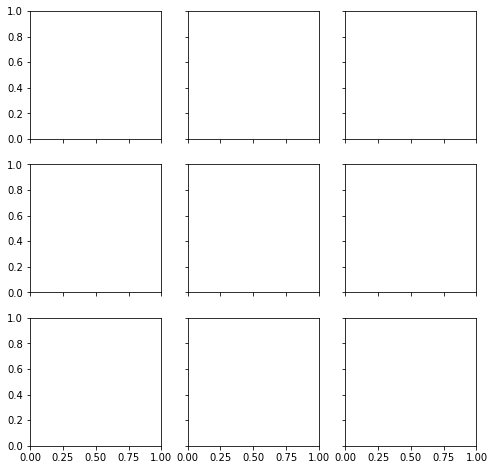

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

#Нейросеть

In [ ]:
vgg_16 = models.vgg16(pretrained=True)
vgg_16 = vgg_16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
resnet_50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
resnet_101 = models.resnet101(pretrained=True)

In [ ]:
resnet_34 = resnet_34.cuda()

In [ ]:
resnet_50 = resnet_50.cuda()

In [ ]:
resnet_101 = resnet_101.cuda()

###ResNet

ResNet #https://pytorch.org/hub/pytorch_vision_resnet/

In [ ]:
resnet_34 = models.resnet34(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet_34.to(device)

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nnBCELoss.. write it from scratch
    loss = y_pred - y_real*y_pred + (1 + torch.exp(-y_pred)).log()
    return loss.mean()

##Обучение

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # Здесь я развлекался разными оптимизаторами с разными параметрами, AdamW на стандартых параметрах давал лучщий результат на 2 эпохах
        #opt = torch.optim.Adam(model.parameters()) # 0.5
        #opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #0.35
        #opt = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10) #0.4
        #opt = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True) #0.4
        #opt = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
        #opt = torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) #0.55

        opt = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) #0.7
       
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.BCELoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if epoch % 10 == 0:
              filepath = f'/content/gdrive/MyDrive/museum/model_resnet_34_50_{epoch}.pth'
              torch.save(model.state_dict(), filepath)  
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = 15#len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
#vgg_16.classifier[6] = nn.Linear(4096,n_classes)
##res_net = resnet.to(DEVICE)
#ResNet_152 = resnet_152.to(DEVICE)
#ResNet_34 = resnet_34.to(DEVICE)
#ResNet_50 = resnet_50.to(DEVICE)
print("we will classify :{}".format(n_classes))
#print(simple_cnn)
#print(res_net)
#print(ResNet_152)
#print(ResNet_34)

we will classify :15


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Aug 10 13:40:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

##Процесс обучения

In [ ]:
resnet_34_256 = train(train_dataset, val_dataset, model=model , epochs=50, batch_size=16)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 2.113193594774946


epoch:   2%|▏         | 1/50 [06:23<5:13:18, 383.65s/it]


Epoch 001 train_loss: 2.1132     val_loss 1.6791 train_acc 0.3181 val_acc 0.4569
loss 2.7284772319286144


epoch:   4%|▍         | 2/50 [12:36<5:04:17, 380.36s/it]


Epoch 002 train_loss: 2.7285     val_loss 2.6415 train_acc 0.1112 val_acc 0.1345
loss 2.5885610653906643


epoch:   6%|▌         | 3/50 [18:41<4:54:22, 375.79s/it]


Epoch 003 train_loss: 2.5886     val_loss 2.4685 train_acc 0.1490 val_acc 0.1901
loss 2.4575956462144184


epoch:   8%|▊         | 4/50 [24:45<4:45:20, 372.17s/it]


Epoch 004 train_loss: 2.4576     val_loss 2.2928 train_acc 0.2010 val_acc 0.2521
loss 2.2757468497385833


epoch:  10%|█         | 5/50 [30:54<4:38:31, 371.37s/it]


Epoch 005 train_loss: 2.2757     val_loss 2.2312 train_acc 0.2623 val_acc 0.2731
loss 2.1102249906176613


epoch:  12%|█▏        | 6/50 [37:02<4:31:29, 370.22s/it]


Epoch 006 train_loss: 2.1102     val_loss 2.1041 train_acc 0.3158 val_acc 0.3193
loss 1.960277177706486


epoch:  14%|█▍        | 7/50 [43:06<4:24:07, 368.54s/it]


Epoch 007 train_loss: 1.9603     val_loss 1.8471 train_acc 0.3587 val_acc 0.4039
loss 1.7869964756217658


epoch:  16%|█▌        | 8/50 [49:09<4:16:47, 366.85s/it]


Epoch 008 train_loss: 1.7870     val_loss 1.6877 train_acc 0.4058 val_acc 0.4223
loss 1.6350139544791533


epoch:  18%|█▊        | 9/50 [55:12<4:09:50, 365.61s/it]


Epoch 009 train_loss: 1.6350     val_loss 1.5929 train_acc 0.4624 val_acc 0.4690
loss 1.4818537111709766


epoch:  20%|██        | 10/50 [1:01:16<4:03:25, 365.13s/it]


Epoch 010 train_loss: 1.4819     val_loss 1.5512 train_acc 0.5089 val_acc 0.5016
loss 1.3726417125106192


epoch:  22%|██▏       | 11/50 [1:07:14<3:56:00, 363.09s/it]


Epoch 011 train_loss: 1.3726     val_loss 1.3852 train_acc 0.5485 val_acc 0.5415
loss 1.252837080915435


epoch:  24%|██▍       | 12/50 [1:13:14<3:49:18, 362.08s/it]


Epoch 012 train_loss: 1.2528     val_loss 1.2587 train_acc 0.5858 val_acc 0.5914
loss 1.145520460872757


epoch:  26%|██▌       | 13/50 [1:19:12<3:42:33, 360.92s/it]


Epoch 013 train_loss: 1.1455     val_loss 1.2015 train_acc 0.6098 val_acc 0.6176
loss 1.0624269382292484


epoch:  28%|██▊       | 14/50 [1:25:11<3:36:06, 360.17s/it]


Epoch 014 train_loss: 1.0624     val_loss 1.1351 train_acc 0.6485 val_acc 0.6218
loss 0.9813598655685991


epoch:  30%|███       | 15/50 [1:31:08<3:29:34, 359.26s/it]


Epoch 015 train_loss: 0.9814     val_loss 1.1101 train_acc 0.6709 val_acc 0.6439
loss 0.8894101189715522


epoch:  32%|███▏      | 16/50 [1:37:05<3:23:17, 358.76s/it]


Epoch 016 train_loss: 0.8894     val_loss 1.0716 train_acc 0.6996 val_acc 0.6513
loss 0.8346778086754454


epoch:  34%|███▍      | 17/50 [1:43:03<3:17:03, 358.28s/it]


Epoch 017 train_loss: 0.8347     val_loss 1.0583 train_acc 0.7227 val_acc 0.6528
loss 0.7775907738536012


epoch:  36%|███▌      | 18/50 [1:49:01<3:11:05, 358.30s/it]


Epoch 018 train_loss: 0.7776     val_loss 1.0565 train_acc 0.7349 val_acc 0.6649
loss 0.7335235204766778


epoch:  38%|███▊      | 19/50 [1:55:00<3:05:17, 358.64s/it]


Epoch 019 train_loss: 0.7335     val_loss 1.0125 train_acc 0.7530 val_acc 0.6875
loss 0.6395894436776137


epoch:  40%|████      | 20/50 [2:00:59<2:59:17, 358.60s/it]


Epoch 020 train_loss: 0.6396     val_loss 0.9522 train_acc 0.7819 val_acc 0.7080
loss 0.6085230449960679


epoch:  42%|████▏     | 21/50 [2:06:59<2:53:35, 359.16s/it]


Epoch 021 train_loss: 0.6085     val_loss 1.0570 train_acc 0.7882 val_acc 0.6870
loss 0.5752741745686164


epoch:  44%|████▍     | 22/50 [2:12:58<2:47:28, 358.88s/it]


Epoch 022 train_loss: 0.5753     val_loss 0.9767 train_acc 0.8092 val_acc 0.7043
loss 0.5543893711531863


epoch:  46%|████▌     | 23/50 [2:18:58<2:41:39, 359.23s/it]


Epoch 023 train_loss: 0.5544     val_loss 1.1805 train_acc 0.8172 val_acc 0.6880
loss 0.4954712473336054


epoch:  48%|████▊     | 24/50 [2:24:57<2:35:41, 359.30s/it]


Epoch 024 train_loss: 0.4955     val_loss 1.1112 train_acc 0.8307 val_acc 0.7122
loss 0.45627024678998634


epoch:  50%|█████     | 25/50 [2:30:56<2:29:36, 359.07s/it]


Epoch 025 train_loss: 0.4563     val_loss 1.0557 train_acc 0.8487 val_acc 0.7106
loss 0.3985432267126416


epoch:  52%|█████▏    | 26/50 [2:36:54<2:23:33, 358.89s/it]


Epoch 026 train_loss: 0.3985     val_loss 1.1319 train_acc 0.8624 val_acc 0.7080
loss 0.4212650223648181


epoch:  54%|█████▍    | 27/50 [2:42:53<2:17:34, 358.87s/it]


Epoch 027 train_loss: 0.4213     val_loss 1.1578 train_acc 0.8598 val_acc 0.7138
loss 0.34656243674269244


epoch:  56%|█████▌    | 28/50 [2:48:52<2:11:36, 358.93s/it]


Epoch 028 train_loss: 0.3466     val_loss 1.1659 train_acc 0.8822 val_acc 0.7327
loss 0.3478070599932213


epoch:  58%|█████▊    | 29/50 [2:54:53<2:05:48, 359.46s/it]


Epoch 029 train_loss: 0.3478     val_loss 1.2200 train_acc 0.8806 val_acc 0.6896
loss 0.3299671287337939


epoch:  60%|██████    | 30/50 [3:00:52<1:59:50, 359.53s/it]


Epoch 030 train_loss: 0.3300     val_loss 1.2119 train_acc 0.8860 val_acc 0.6996
loss 0.31073899551735623


epoch:  62%|██████▏   | 31/50 [3:06:50<1:53:40, 358.99s/it]


Epoch 031 train_loss: 0.3107     val_loss 1.2536 train_acc 0.8932 val_acc 0.7190
loss 0.2728362410819727


epoch:  64%|██████▍   | 32/50 [3:12:50<1:47:46, 359.27s/it]


Epoch 032 train_loss: 0.2728     val_loss 1.1583 train_acc 0.9060 val_acc 0.7321
loss 0.25827746730068235


epoch:  66%|██████▌   | 33/50 [3:18:48<1:41:39, 358.82s/it]


Epoch 033 train_loss: 0.2583     val_loss 1.2331 train_acc 0.9121 val_acc 0.7253
loss 0.2606473261652206


epoch:  68%|██████▊   | 34/50 [3:24:46<1:35:36, 358.56s/it]


Epoch 034 train_loss: 0.2606     val_loss 1.1890 train_acc 0.9093 val_acc 0.7201
loss 0.22454307936601528


epoch:  70%|███████   | 35/50 [3:30:43<1:29:33, 358.22s/it]


Epoch 035 train_loss: 0.2245     val_loss 1.2014 train_acc 0.9231 val_acc 0.7437
loss 0.25009672374514136


epoch:  72%|███████▏  | 36/50 [3:36:41<1:23:34, 358.17s/it]


Epoch 036 train_loss: 0.2501     val_loss 1.2461 train_acc 0.9153 val_acc 0.7411
loss 0.22815583114765314


epoch:  74%|███████▍  | 37/50 [3:42:39<1:17:36, 358.18s/it]


Epoch 037 train_loss: 0.2282     val_loss 1.3314 train_acc 0.9235 val_acc 0.7432
loss 0.18954480013350958


epoch:  76%|███████▌  | 38/50 [3:48:39<1:11:43, 358.62s/it]


Epoch 038 train_loss: 0.1895     val_loss 1.4641 train_acc 0.9359 val_acc 0.7258
loss 0.19950084820981934


epoch:  78%|███████▊  | 39/50 [3:54:45<1:06:09, 360.85s/it]


Epoch 039 train_loss: 0.1995     val_loss 1.3285 train_acc 0.9289 val_acc 0.7432
loss 0.18355756126088546


epoch:  80%|████████  | 40/50 [4:00:47<1:00:10, 361.02s/it]


Epoch 040 train_loss: 0.1836     val_loss 1.2939 train_acc 0.9414 val_acc 0.7295
loss 0.1689523721390328


epoch:  82%|████████▏ | 41/50 [4:06:48<54:10, 361.21s/it]


Epoch 041 train_loss: 0.1690     val_loss 1.5142 train_acc 0.9424 val_acc 0.7363
loss 0.16816154485506446


epoch:  84%|████████▍ | 42/50 [4:12:52<48:14, 361.86s/it]


Epoch 042 train_loss: 0.1682     val_loss 1.4994 train_acc 0.9447 val_acc 0.7453
loss 0.16489188186824322


epoch:  86%|████████▌ | 43/50 [4:18:54<42:14, 362.07s/it]


Epoch 043 train_loss: 0.1649     val_loss 1.2857 train_acc 0.9443 val_acc 0.7395
loss 0.1568481522644557


epoch:  88%|████████▊ | 44/50 [4:24:56<36:12, 362.04s/it]


Epoch 044 train_loss: 0.1568     val_loss 1.3697 train_acc 0.9505 val_acc 0.7180
loss 0.158154256904696


epoch:  90%|█████████ | 45/50 [4:30:58<30:10, 362.04s/it]


Epoch 045 train_loss: 0.1582     val_loss 1.5522 train_acc 0.9473 val_acc 0.7405
loss 0.20657672941605157


epoch:  92%|█████████▏| 46/50 [4:36:59<24:06, 361.68s/it]


Epoch 046 train_loss: 0.2066     val_loss 1.4356 train_acc 0.9349 val_acc 0.7395
loss 0.12609188017004602


epoch:  94%|█████████▍| 47/50 [4:43:01<18:04, 361.66s/it]


Epoch 047 train_loss: 0.1261     val_loss 1.5930 train_acc 0.9582 val_acc 0.7511
loss 0.1468253830869758


epoch:  96%|█████████▌| 48/50 [4:49:01<12:02, 361.27s/it]


Epoch 048 train_loss: 0.1468     val_loss 1.4722 train_acc 0.9547 val_acc 0.7353
loss 0.14900012015031144


epoch:  98%|█████████▊| 49/50 [4:55:00<06:00, 360.50s/it]


Epoch 049 train_loss: 0.1490     val_loss 1.4148 train_acc 0.9527 val_acc 0.7511
loss 0.11808670332913902


epoch: 100%|██████████| 50/50 [5:00:59<00:00, 361.20s/it]


Epoch 050 train_loss: 0.1181     val_loss 1.5550 train_acc 0.9608 val_acc 0.7568


In [ ]:
#Сохранение обученной модели
filepath = '/content/gdrive/MyDrive/museum/resnet_34_50_256_13.pth'
torch.save(model.state_dict(), filepath)


In [ ]:
resnet_34_256_50 = train(train_dataset, val_dataset, model=model , epochs=20, batch_size=16)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.5346564870922506


epoch:   5%|▌         | 1/20 [06:06<1:56:03, 366.50s/it]


Epoch 001 train_loss: 0.5347     val_loss 0.5481 train_acc 0.8311 val_acc 0.8288
loss 0.47289273465255727


epoch:  10%|█         | 2/20 [12:12<1:49:52, 366.25s/it]


Epoch 002 train_loss: 0.4729     val_loss 0.6555 train_acc 0.8500 val_acc 0.7868
loss 0.4404904847020278


epoch:  15%|█▌        | 3/20 [18:16<1:43:36, 365.68s/it]


Epoch 003 train_loss: 0.4405     val_loss 0.6231 train_acc 0.8557 val_acc 0.8225
loss 0.3856798534174593


epoch:  20%|██        | 4/20 [24:19<1:37:19, 364.94s/it]


Epoch 004 train_loss: 0.3857     val_loss 0.5946 train_acc 0.8738 val_acc 0.8251
loss 0.37720028637107517


epoch:  25%|██▌       | 5/20 [30:21<1:30:58, 363.92s/it]


Epoch 005 train_loss: 0.3772     val_loss 0.6767 train_acc 0.8694 val_acc 0.7873
loss 0.3475030717969525


epoch:  30%|███       | 6/20 [36:22<1:24:43, 363.10s/it]


Epoch 006 train_loss: 0.3475     val_loss 0.6617 train_acc 0.8867 val_acc 0.8099
loss 0.3190750657145132


epoch:  35%|███▌      | 7/20 [42:21<1:18:23, 361.84s/it]


Epoch 007 train_loss: 0.3191     val_loss 0.6357 train_acc 0.8930 val_acc 0.8188
loss 0.29494278674491314


epoch:  40%|████      | 8/20 [48:18<1:12:05, 360.44s/it]


Epoch 008 train_loss: 0.2949     val_loss 0.6866 train_acc 0.9009 val_acc 0.8199
loss 0.25946262935815634


epoch:  45%|████▌     | 9/20 [54:16<1:05:57, 359.77s/it]


Epoch 009 train_loss: 0.2595     val_loss 0.7982 train_acc 0.9118 val_acc 0.7952
loss 0.2715355690532163


epoch:  50%|█████     | 10/20 [1:00:14<59:52, 359.23s/it]


Epoch 010 train_loss: 0.2715     val_loss 0.9005 train_acc 0.9098 val_acc 0.7805
loss 0.26576421594675054


epoch:  55%|█████▌    | 11/20 [1:06:13<53:50, 358.96s/it]


Epoch 011 train_loss: 0.2658     val_loss 0.7860 train_acc 0.9114 val_acc 0.8009
loss 0.26483762013812023


epoch:  60%|██████    | 12/20 [1:12:14<47:58, 359.76s/it]


Epoch 012 train_loss: 0.2648     val_loss 0.8733 train_acc 0.9123 val_acc 0.8062
loss 0.22974821684506386


epoch:  65%|██████▌   | 13/20 [1:18:16<42:02, 360.38s/it]


Epoch 013 train_loss: 0.2297     val_loss 0.7820 train_acc 0.9223 val_acc 0.8162
loss 0.20882018625994503


epoch:  70%|███████   | 14/20 [1:24:18<36:04, 360.83s/it]


Epoch 014 train_loss: 0.2088     val_loss 0.9041 train_acc 0.9301 val_acc 0.7973
loss 0.22339822186407546


epoch:  75%|███████▌  | 15/20 [1:30:20<30:06, 361.28s/it]


Epoch 015 train_loss: 0.2234     val_loss 0.8172 train_acc 0.9291 val_acc 0.8162
loss 0.21130384217832937


epoch:  80%|████████  | 16/20 [1:36:22<24:05, 361.46s/it]


Epoch 016 train_loss: 0.2113     val_loss 0.9401 train_acc 0.9308 val_acc 0.7925
loss 0.20251295107471592


epoch:  85%|████████▌ | 17/20 [1:42:21<18:01, 360.64s/it]


Epoch 017 train_loss: 0.2025     val_loss 0.9756 train_acc 0.9321 val_acc 0.7904
loss 0.2266249597002165


epoch:  90%|█████████ | 18/20 [1:48:22<12:01, 360.67s/it]


Epoch 018 train_loss: 0.2266     val_loss 0.9703 train_acc 0.9294 val_acc 0.7946
loss 0.17829761234717312


epoch:  95%|█████████▌| 19/20 [1:54:22<06:00, 360.56s/it]


Epoch 019 train_loss: 0.1783     val_loss 0.9461 train_acc 0.9414 val_acc 0.8046
loss 0.15009747770828838


epoch: 100%|██████████| 20/20 [2:00:23<00:00, 361.16s/it]


Epoch 020 train_loss: 0.1501     val_loss 1.0331 train_acc 0.9491 val_acc 0.7941


In [ ]:
#Загрузка предобученной модели
filepath = '/content/gdrive/MyDrive/museum/model_resnet_34_30_256.pth'
model.load_state_dict(torch.load(filepath))
model.eval()

In [ ]:
resnet_34_fit_20 = train(train_dataset, val_dataset, model=model , epochs=20, batch_size=16)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.9048529818556668


epoch:   5%|▌         | 1/20 [05:11<1:38:36, 311.38s/it]


Epoch 001 train_loss: 0.9049     val_loss 1.3371 train_acc 0.6914 val_acc 0.6048
loss 0.8757314058203324


epoch:  10%|█         | 2/20 [10:20<1:33:12, 310.68s/it]


Epoch 002 train_loss: 0.8757     val_loss 1.2846 train_acc 0.6998 val_acc 0.6011
loss 0.7910477521957135


epoch:  15%|█▌        | 3/20 [15:28<1:27:49, 309.95s/it]


Epoch 003 train_loss: 0.7910     val_loss 1.3989 train_acc 0.7259 val_acc 0.5987
loss 0.7840147896432409


epoch:  20%|██        | 4/20 [20:37<1:22:31, 309.46s/it]


Epoch 004 train_loss: 0.7840     val_loss 1.5463 train_acc 0.7333 val_acc 0.5692
loss 0.7382171006958469


epoch:  25%|██▌       | 5/20 [25:45<1:17:17, 309.17s/it]


Epoch 005 train_loss: 0.7382     val_loss 1.4291 train_acc 0.7471 val_acc 0.6072
loss 0.7066010031240438


epoch:  30%|███       | 6/20 [30:54<1:12:06, 309.02s/it]


Epoch 006 train_loss: 0.7066     val_loss 1.4257 train_acc 0.7614 val_acc 0.6164
loss 0.6765587319151248


epoch:  35%|███▌      | 7/20 [36:03<1:06:56, 308.99s/it]


Epoch 007 train_loss: 0.6766     val_loss 1.5219 train_acc 0.7710 val_acc 0.6005
loss 0.6370924557833111


epoch:  40%|████      | 8/20 [41:11<1:01:44, 308.73s/it]


Epoch 008 train_loss: 0.6371     val_loss 1.4300 train_acc 0.7804 val_acc 0.6097
loss 0.6284384597945057


epoch:  45%|████▌     | 9/20 [46:19<56:35, 308.64s/it]


Epoch 009 train_loss: 0.6284     val_loss 1.5007 train_acc 0.7833 val_acc 0.6311
loss 0.5930305748837057


epoch:  50%|█████     | 10/20 [51:28<51:28, 308.85s/it]


Epoch 010 train_loss: 0.5930     val_loss 1.4169 train_acc 0.7888 val_acc 0.6409
loss 0.5500882384823818


epoch:  55%|█████▌    | 11/20 [56:36<46:17, 308.59s/it]


Epoch 011 train_loss: 0.5501     val_loss 1.5099 train_acc 0.8137 val_acc 0.6446
loss 0.5078528942357675


epoch:  60%|██████    | 12/20 [1:01:43<41:02, 307.86s/it]


Epoch 012 train_loss: 0.5079     val_loss 1.6265 train_acc 0.8237 val_acc 0.6379
loss 0.5165894253824661


epoch:  65%|██████▌   | 13/20 [1:06:49<35:51, 307.37s/it]


Epoch 013 train_loss: 0.5166     val_loss 1.6020 train_acc 0.8188 val_acc 0.6409
loss 0.4948435877419375


epoch:  70%|███████   | 14/20 [1:11:54<30:40, 306.82s/it]


Epoch 014 train_loss: 0.4948     val_loss 1.6002 train_acc 0.8317 val_acc 0.6385
loss 0.5020398704420312


epoch:  75%|███████▌  | 15/20 [1:17:01<25:33, 306.79s/it]


Epoch 015 train_loss: 0.5020     val_loss 1.5756 train_acc 0.8321 val_acc 0.6207
loss 0.43437506695539735


epoch:  80%|████████  | 16/20 [1:22:08<20:27, 306.95s/it]


Epoch 016 train_loss: 0.4344     val_loss 1.7767 train_acc 0.8499 val_acc 0.6317
loss 0.4226695075022434


epoch:  85%|████████▌ | 17/20 [1:27:15<15:20, 306.76s/it]


Epoch 017 train_loss: 0.4227     val_loss 1.7745 train_acc 0.8589 val_acc 0.6275
loss 0.4111985947595897


epoch:  90%|█████████ | 18/20 [1:32:21<10:13, 306.61s/it]


Epoch 018 train_loss: 0.4112     val_loss 1.7860 train_acc 0.8623 val_acc 0.6360
loss 0.39033074127327577


epoch:  95%|█████████▌| 19/20 [1:37:27<05:06, 306.47s/it]


Epoch 019 train_loss: 0.3903     val_loss 1.6966 train_acc 0.8689 val_acc 0.6532
loss 0.4006673316379972


epoch: 100%|██████████| 20/20 [1:42:33<00:00, 307.68s/it]


Epoch 020 train_loss: 0.4007     val_loss 1.7596 train_acc 0.8638 val_acc 0.6250


In [ ]:
model_2 = resnet_34.to(device)
model_2.load_state_dict(torch.load(filepath))
model_2.eval()
resnet_34_fit_20_20 = train(train_dataset, val_dataset, model=model_2 , epochs=20, batch_size=16)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.3641339368643422


epoch:   5%|▌         | 1/20 [05:11<1:38:40, 311.59s/it]


Epoch 001 train_loss: 0.3641     val_loss 1.9734 train_acc 0.8760 val_acc 0.6422
loss 0.4021269358828469


epoch:  10%|█         | 2/20 [10:22<1:33:23, 311.30s/it]


Epoch 002 train_loss: 0.4021     val_loss 1.7306 train_acc 0.8644 val_acc 0.6324
loss 0.3261399204337519


epoch:  15%|█▌        | 3/20 [15:32<1:28:08, 311.06s/it]


Epoch 003 train_loss: 0.3261     val_loss 1.9154 train_acc 0.8938 val_acc 0.6477
loss 0.3223710390982626


epoch:  20%|██        | 4/20 [20:43<1:22:57, 311.07s/it]


Epoch 004 train_loss: 0.3224     val_loss 1.9895 train_acc 0.8893 val_acc 0.6513
loss 0.3197908136823209


epoch:  25%|██▌       | 5/20 [25:54<1:17:43, 310.91s/it]


Epoch 005 train_loss: 0.3198     val_loss 1.8718 train_acc 0.8940 val_acc 0.6397
loss 0.34042783003312604


epoch:  30%|███       | 6/20 [31:03<1:12:26, 310.49s/it]


Epoch 006 train_loss: 0.3404     val_loss 1.9386 train_acc 0.8903 val_acc 0.6587
loss 0.2765578291518918


epoch:  35%|███▌      | 7/20 [36:13<1:07:12, 310.17s/it]


Epoch 007 train_loss: 0.2766     val_loss 1.8439 train_acc 0.9101 val_acc 0.6544
loss 0.2733268081043159


epoch:  40%|████      | 8/20 [41:22<1:02:00, 310.01s/it]


Epoch 008 train_loss: 0.2733     val_loss 2.0075 train_acc 0.9071 val_acc 0.6618
loss 0.26551301219786694


epoch:  45%|████▌     | 9/20 [46:33<56:52, 310.25s/it]


Epoch 009 train_loss: 0.2655     val_loss 2.0245 train_acc 0.9085 val_acc 0.6624
loss 0.30550202922789027


epoch:  50%|█████     | 10/20 [51:44<51:42, 310.29s/it]


Epoch 010 train_loss: 0.3055     val_loss 1.9598 train_acc 0.8989 val_acc 0.6342
loss 0.25702390375887985


epoch:  55%|█████▌    | 11/20 [56:54<46:31, 310.18s/it]


Epoch 011 train_loss: 0.2570     val_loss 2.0729 train_acc 0.9132 val_acc 0.6452
loss 0.25637376097828346


epoch:  60%|██████    | 12/20 [1:02:07<41:29, 311.14s/it]


Epoch 012 train_loss: 0.2564     val_loss 2.1102 train_acc 0.9152 val_acc 0.6562
loss 0.273656088950149


epoch:  65%|██████▌   | 13/20 [1:07:21<36:23, 311.96s/it]


Epoch 013 train_loss: 0.2737     val_loss 1.9773 train_acc 0.9107 val_acc 0.6630
loss 0.26853857843473167


epoch:  70%|███████   | 14/20 [1:12:32<31:09, 311.62s/it]


Epoch 014 train_loss: 0.2685     val_loss 1.9638 train_acc 0.9134 val_acc 0.6471
loss 0.22192129180492723


epoch:  75%|███████▌  | 15/20 [1:17:44<25:58, 311.73s/it]


Epoch 015 train_loss: 0.2219     val_loss 2.0515 train_acc 0.9269 val_acc 0.6201
loss 0.25088827279731146


epoch:  80%|████████  | 16/20 [1:22:55<20:46, 311.69s/it]


Epoch 016 train_loss: 0.2509     val_loss 1.8901 train_acc 0.9136 val_acc 0.6446
loss 0.20471409360841647


epoch:  85%|████████▌ | 17/20 [1:28:07<15:35, 311.76s/it]


Epoch 017 train_loss: 0.2047     val_loss 1.9395 train_acc 0.9346 val_acc 0.6612
loss 0.22310464210150874


epoch:  90%|█████████ | 18/20 [1:33:21<10:24, 312.35s/it]


Epoch 018 train_loss: 0.2231     val_loss 2.1777 train_acc 0.9220 val_acc 0.6471
loss 0.22212825568843317


epoch:  95%|█████████▌| 19/20 [1:38:35<05:12, 312.77s/it]


Epoch 019 train_loss: 0.2221     val_loss 2.0183 train_acc 0.9269 val_acc 0.6360
loss 0.22308778918646519


epoch: 100%|██████████| 20/20 [1:43:45<00:00, 311.27s/it]


Epoch 020 train_loss: 0.2231     val_loss 2.2320 train_acc 0.9240 val_acc 0.6605


In [ ]:
history_101 = train(train_dataset, val_dataset, model=resnet_101 , epochs=30, batch_size=4)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 2.744967572069207


epoch:   3%|▎         | 1/30 [06:58<3:22:21, 418.67s/it]


Epoch 001 train_loss: 2.7450     val_loss 2.7317 train_acc 0.1322 val_acc 0.1950
loss 2.7119993256084687


epoch:   7%|▋         | 2/30 [13:47<3:14:00, 415.75s/it]


Epoch 002 train_loss: 2.7120     val_loss 2.6917 train_acc 0.1029 val_acc 0.1149
loss 2.6943943642365222


epoch:  10%|█         | 3/30 [20:34<3:05:57, 413.23s/it]


Epoch 003 train_loss: 2.6944     val_loss 2.6827 train_acc 0.1019 val_acc 0.1149
loss 2.6867796375971067


epoch:  13%|█▎        | 4/30 [27:23<2:58:28, 411.86s/it]


Epoch 004 train_loss: 2.6868     val_loss 2.6916 train_acc 0.1049 val_acc 0.0746
loss 2.6822612147653793


epoch:  17%|█▋        | 5/30 [34:11<2:51:08, 410.74s/it]


Epoch 005 train_loss: 2.6823     val_loss 2.6781 train_acc 0.1115 val_acc 0.1149
loss 2.68114047411893


epoch:  20%|██        | 6/30 [41:00<2:44:04, 410.20s/it]


Epoch 006 train_loss: 2.6811     val_loss 2.6780 train_acc 0.1115 val_acc 0.1149
loss 2.678240211008036


epoch:  23%|██▎       | 7/30 [47:49<2:37:01, 409.64s/it]


Epoch 007 train_loss: 2.6782     val_loss 2.6752 train_acc 0.1145 val_acc 0.1149
loss 2.6773076255630457


epoch:  27%|██▋       | 8/30 [54:37<2:30:06, 409.36s/it]


Epoch 008 train_loss: 2.6773     val_loss 2.6721 train_acc 0.1137 val_acc 0.1149
loss 2.6758101124440934


epoch:  30%|███       | 9/30 [1:01:27<2:23:16, 409.35s/it]


Epoch 009 train_loss: 2.6758     val_loss 2.6726 train_acc 0.1145 val_acc 0.1149
loss 2.677071123270845


epoch:  33%|███▎      | 10/30 [1:08:14<2:16:15, 408.75s/it]


Epoch 010 train_loss: 2.6771     val_loss 2.6731 train_acc 0.1139 val_acc 0.1149
loss 2.67460089868516


epoch:  37%|███▋      | 11/30 [1:15:00<2:09:10, 407.94s/it]


Epoch 011 train_loss: 2.6746     val_loss 2.6719 train_acc 0.1147 val_acc 0.1149
loss 2.6740790785281954


epoch:  40%|████      | 12/30 [1:21:44<2:02:03, 406.85s/it]


Epoch 012 train_loss: 2.6741     val_loss 2.6715 train_acc 0.1147 val_acc 0.1149
loss 2.6741404892860046


epoch:  43%|████▎     | 13/30 [1:28:28<1:55:00, 405.90s/it]


Epoch 013 train_loss: 2.6741     val_loss 2.6709 train_acc 0.1147 val_acc 0.1149


In [ ]:
history_50 = train(train_dataset, val_dataset, model=resnet_50 , epochs=30, batch_size=4)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 2.689310606359561


epoch:   3%|▎         | 1/30 [06:00<2:54:13, 360.47s/it]


Epoch 001 train_loss: 2.6893     val_loss 2.5612 train_acc 0.1514 val_acc 0.2090
loss 2.673704508367164


epoch:   7%|▋         | 2/30 [11:52<2:47:01, 357.90s/it]


Epoch 002 train_loss: 2.6737     val_loss 2.6636 train_acc 0.1280 val_acc 0.1449
loss 2.5523078269655373


epoch:  10%|█         | 3/30 [17:40<2:39:43, 354.93s/it]


Epoch 003 train_loss: 2.5523     val_loss 2.6407 train_acc 0.1799 val_acc 0.1620
loss 2.444236939188515


epoch:  13%|█▎        | 4/30 [23:27<2:32:47, 352.61s/it]


Epoch 004 train_loss: 2.4442     val_loss 2.3560 train_acc 0.2001 val_acc 0.2366
loss 2.3618965937825074


epoch:  17%|█▋        | 5/30 [29:12<2:25:58, 350.34s/it]


Epoch 005 train_loss: 2.3619     val_loss 2.3989 train_acc 0.2247 val_acc 0.2286
loss 2.301041788168816


epoch:  20%|██        | 6/30 [34:58<2:19:35, 348.98s/it]


Epoch 006 train_loss: 2.3010     val_loss 2.2212 train_acc 0.2455 val_acc 0.2408
loss 2.2068511038751453


epoch:  23%|██▎       | 7/30 [40:49<2:14:02, 349.66s/it]


Epoch 007 train_loss: 2.2069     val_loss 2.1819 train_acc 0.2785 val_acc 0.2958
loss 2.1448239355234957


epoch:  27%|██▋       | 8/30 [46:41<2:08:29, 350.41s/it]


Epoch 008 train_loss: 2.1448     val_loss 2.0080 train_acc 0.2897 val_acc 0.3301
loss 2.031664823431646


epoch:  30%|███       | 9/30 [52:35<2:02:56, 351.25s/it]


Epoch 009 train_loss: 2.0317     val_loss 2.0769 train_acc 0.3331 val_acc 0.3282
loss 1.9633249036888816


epoch:  33%|███▎      | 10/30 [58:26<1:57:08, 351.42s/it]


Epoch 010 train_loss: 1.9633     val_loss 1.9000 train_acc 0.3582 val_acc 0.3716
loss 1.862563526147055


epoch:  37%|███▋      | 11/30 [1:04:17<1:51:15, 351.33s/it]


Epoch 011 train_loss: 1.8626     val_loss 1.7937 train_acc 0.3892 val_acc 0.4095
loss 1.7700757435063763


epoch:  40%|████      | 12/30 [1:10:10<1:45:27, 351.55s/it]


Epoch 012 train_loss: 1.7701     val_loss 1.7654 train_acc 0.4277 val_acc 0.4205
loss 1.7026587512401807


epoch:  43%|████▎     | 13/30 [1:16:00<1:39:32, 351.30s/it]


Epoch 013 train_loss: 1.7027     val_loss 1.6571 train_acc 0.4399 val_acc 0.4670
loss 1.6417971008928598


epoch:  47%|████▋     | 14/30 [1:21:50<1:33:33, 350.82s/it]


Epoch 014 train_loss: 1.6418     val_loss 1.5494 train_acc 0.4607 val_acc 0.4969
loss 1.577399626507833


epoch:  50%|█████     | 15/30 [1:27:40<1:27:40, 350.73s/it]


Epoch 015 train_loss: 1.5774     val_loss 1.4973 train_acc 0.4837 val_acc 0.5189
loss 1.5052298928421983


epoch:  53%|█████▎    | 16/30 [1:33:31<1:21:50, 350.72s/it]


Epoch 016 train_loss: 1.5052     val_loss 1.5081 train_acc 0.5077 val_acc 0.5128
loss 1.4443972302083088


epoch:  57%|█████▋    | 17/30 [1:39:21<1:15:56, 350.51s/it]


Epoch 017 train_loss: 1.4444     val_loss 1.3959 train_acc 0.5202 val_acc 0.5397
loss 1.4173633645318249


epoch:  60%|██████    | 18/30 [1:45:12<1:10:06, 350.57s/it]


Epoch 018 train_loss: 1.4174     val_loss 1.5459 train_acc 0.5300 val_acc 0.4927
loss 1.3790065178491278


epoch:  63%|██████▎   | 19/30 [1:51:01<1:04:10, 350.04s/it]


Epoch 019 train_loss: 1.3790     val_loss 1.4932 train_acc 0.5511 val_acc 0.5281
loss 1.302414300275045


epoch:  67%|██████▋   | 20/30 [1:56:53<58:26, 350.60s/it]


Epoch 020 train_loss: 1.3024     val_loss 1.2948 train_acc 0.5731 val_acc 0.5850
loss 1.2842119199989672


epoch:  70%|███████   | 21/30 [2:02:43<52:34, 350.48s/it]


Epoch 021 train_loss: 1.2842     val_loss 1.3348 train_acc 0.5711 val_acc 0.5782
loss 1.2532442185895696


epoch:  73%|███████▎  | 22/30 [2:08:33<46:43, 350.48s/it]


Epoch 022 train_loss: 1.2532     val_loss 1.3482 train_acc 0.5905 val_acc 0.5703
loss 1.2166333567706327


epoch:  77%|███████▋  | 23/30 [2:14:25<40:56, 350.95s/it]


Epoch 023 train_loss: 1.2166     val_loss 1.3462 train_acc 0.6011 val_acc 0.5746
loss 1.1878807212377138


epoch:  80%|████████  | 24/30 [2:20:16<35:05, 350.93s/it]


Epoch 024 train_loss: 1.1879     val_loss 1.2788 train_acc 0.6214 val_acc 0.5972
loss 1.1458920289647705


epoch:  83%|████████▎ | 25/30 [2:26:05<29:10, 350.17s/it]


Epoch 025 train_loss: 1.1459     val_loss 1.2687 train_acc 0.6210 val_acc 0.5831
loss 1.126422109314223


epoch:  87%|████████▋ | 26/30 [2:31:53<23:18, 349.66s/it]


Epoch 026 train_loss: 1.1264     val_loss 1.2339 train_acc 0.6318 val_acc 0.6137
loss 1.09874190619952


epoch:  90%|█████████ | 27/30 [2:37:40<17:26, 348.90s/it]


Epoch 027 train_loss: 1.0987     val_loss 1.3882 train_acc 0.6363 val_acc 0.5691
loss 1.0603072239237268


epoch:  93%|█████████▎| 28/30 [2:43:29<11:37, 348.80s/it]


Epoch 028 train_loss: 1.0603     val_loss 1.3548 train_acc 0.6416 val_acc 0.5880
loss 1.0523882420762414


epoch:  97%|█████████▋| 29/30 [2:49:17<05:48, 348.53s/it]


Epoch 029 train_loss: 1.0524     val_loss 1.2233 train_acc 0.6461 val_acc 0.6155
loss 1.018664136475837


epoch: 100%|██████████| 30/30 [2:55:05<00:00, 350.17s/it]


Epoch 030 train_loss: 1.0187     val_loss 1.2485 train_acc 0.6595 val_acc 0.6125


In [ ]:
history = train(train_dataset, val_dataset, model=resnet_34 , epochs=30, batch_size=4)


epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 2.7726393333759947


epoch:   3%|▎         | 1/30 [07:42<3:43:25, 462.26s/it]


Epoch 001 train_loss: 2.7726     val_loss 2.8588 train_acc 0.1355 val_acc 0.2035
loss 2.590091760409199


epoch:   7%|▋         | 2/30 [15:24<3:35:43, 462.26s/it]


Epoch 002 train_loss: 2.5901     val_loss 2.4031 train_acc 0.1538 val_acc 0.2378
loss 2.35749378190744


epoch:  10%|█         | 3/30 [23:08<3:28:12, 462.67s/it]


Epoch 003 train_loss: 2.3575     val_loss 2.2167 train_acc 0.2361 val_acc 0.2928
loss 2.1436099695207242


epoch:  13%|█▎        | 4/30 [30:44<3:19:41, 460.82s/it]


Epoch 004 train_loss: 2.1436     val_loss 2.0071 train_acc 0.3056 val_acc 0.3692
loss 1.923577329057353


epoch:  17%|█▋        | 5/30 [38:14<3:10:39, 457.57s/it]


Epoch 005 train_loss: 1.9236     val_loss 1.8575 train_acc 0.3814 val_acc 0.4358
loss 1.7609726199918194


epoch:  20%|██        | 6/30 [45:47<3:02:28, 456.17s/it]


Epoch 006 train_loss: 1.7610     val_loss 1.6834 train_acc 0.4283 val_acc 0.4572
loss 1.5833978369382697


epoch:  23%|██▎       | 7/30 [53:23<2:54:48, 456.03s/it]


Epoch 007 train_loss: 1.5834     val_loss 1.6348 train_acc 0.4825 val_acc 0.4688
loss 1.4777555367207273


epoch:  27%|██▋       | 8/30 [1:00:54<2:46:38, 454.47s/it]


Epoch 008 train_loss: 1.4778     val_loss 1.6051 train_acc 0.5189 val_acc 0.4700
loss 1.3541676271964889


epoch:  30%|███       | 9/30 [1:08:31<2:39:20, 455.26s/it]


Epoch 009 train_loss: 1.3542     val_loss 1.3481 train_acc 0.5540 val_acc 0.5611
loss 1.2696822509124037


epoch:  33%|███▎      | 10/30 [1:16:06<2:31:45, 455.26s/it]


Epoch 010 train_loss: 1.2697     val_loss 1.4182 train_acc 0.5782 val_acc 0.5324
loss 1.1702774035476433


epoch:  37%|███▋      | 11/30 [1:23:46<2:24:35, 456.60s/it]


Epoch 011 train_loss: 1.1703     val_loss 1.5365 train_acc 0.6070 val_acc 0.5348
loss 1.1196847089817528


epoch:  40%|████      | 12/30 [1:31:24<2:17:06, 457.01s/it]


Epoch 012 train_loss: 1.1197     val_loss 1.2760 train_acc 0.6271 val_acc 0.5947
loss 1.042797217175259


epoch:  43%|████▎     | 13/30 [1:38:55<2:09:00, 455.30s/it]


Epoch 013 train_loss: 1.0428     val_loss 1.4049 train_acc 0.6532 val_acc 0.5831
loss 0.9844625230796806


epoch:  47%|████▋     | 14/30 [1:46:22<2:00:44, 452.80s/it]


Epoch 014 train_loss: 0.9845     val_loss 1.1037 train_acc 0.6701 val_acc 0.6516
loss 0.9077594896642599


epoch:  50%|█████     | 15/30 [1:53:54<1:53:09, 452.64s/it]


Epoch 015 train_loss: 0.9078     val_loss 1.1806 train_acc 0.6893 val_acc 0.6326
loss 0.8723144616891401


epoch:  53%|█████▎    | 16/30 [2:01:20<1:45:09, 450.70s/it]


Epoch 016 train_loss: 0.8723     val_loss 1.1743 train_acc 0.7070 val_acc 0.6167
loss 0.8449104069574039


epoch:  57%|█████▋    | 17/30 [2:08:47<1:37:22, 449.42s/it]


Epoch 017 train_loss: 0.8449     val_loss 1.1397 train_acc 0.7156 val_acc 0.6626
loss 0.7567832287260162


epoch:  60%|██████    | 18/30 [2:16:14<1:29:44, 448.75s/it]


Epoch 018 train_loss: 0.7568     val_loss 1.1923 train_acc 0.7451 val_acc 0.6528
loss 0.7283980150829649


epoch:  63%|██████▎   | 19/30 [2:23:45<1:22:22, 449.30s/it]


Epoch 019 train_loss: 0.7284     val_loss 1.1353 train_acc 0.7488 val_acc 0.6736
loss 0.666102664797554


epoch:  67%|██████▋   | 20/30 [2:31:15<1:14:57, 449.71s/it]


Epoch 020 train_loss: 0.6661     val_loss 1.2716 train_acc 0.7757 val_acc 0.6467
loss 0.6395330443936943


epoch:  70%|███████   | 21/30 [2:38:49<1:07:37, 450.86s/it]


Epoch 021 train_loss: 0.6395     val_loss 1.1708 train_acc 0.7791 val_acc 0.6601
loss 0.5950300167562992


epoch:  73%|███████▎  | 22/30 [2:46:20<1:00:07, 450.96s/it]


Epoch 022 train_loss: 0.5950     val_loss 1.3037 train_acc 0.7989 val_acc 0.6394
loss 0.5681483353178405


epoch:  77%|███████▋  | 23/30 [2:53:46<52:26, 449.53s/it]


Epoch 023 train_loss: 0.5681     val_loss 1.2926 train_acc 0.8117 val_acc 0.6504
loss 0.5486744658066636


epoch:  80%|████████  | 24/30 [3:01:28<45:19, 453.30s/it]


Epoch 024 train_loss: 0.5487     val_loss 1.1177 train_acc 0.8166 val_acc 0.6675
loss 0.5179115875797898


epoch:  83%|████████▎ | 25/30 [3:09:10<37:59, 455.88s/it]


Epoch 025 train_loss: 0.5179     val_loss 1.3112 train_acc 0.8225 val_acc 0.6791
loss 0.5135999631557843


epoch:  87%|████████▋ | 26/30 [3:16:48<30:25, 456.44s/it]


Epoch 026 train_loss: 0.5136     val_loss 1.1919 train_acc 0.8270 val_acc 0.6748
loss 0.44526069798263856


epoch:  90%|█████████ | 27/30 [3:24:23<22:48, 456.13s/it]


Epoch 027 train_loss: 0.4453     val_loss 1.1756 train_acc 0.8529 val_acc 0.6932
loss 0.43017765871365016


epoch:  93%|█████████▎| 28/30 [3:31:54<15:08, 454.44s/it]


Epoch 028 train_loss: 0.4302     val_loss 1.4158 train_acc 0.8498 val_acc 0.6760
loss 0.43487519304412786


epoch:  97%|█████████▋| 29/30 [3:39:11<07:29, 449.34s/it]


Epoch 029 train_loss: 0.4349     val_loss 1.2267 train_acc 0.8527 val_acc 0.6950
loss 0.3893588035825318


epoch: 100%|██████████| 30/30 [3:46:25<00:00, 452.85s/it]


Epoch 030 train_loss: 0.3894     val_loss 1.2713 train_acc 0.8688 val_acc 0.6834


In [ ]:
history_50_20 = train(train_dataset, val_dataset, model=resnet_50 , epochs=20, batch_size=4)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.0075709481536508


epoch:   5%|▌         | 1/20 [05:49<1:50:36, 349.30s/it]


Epoch 001 train_loss: 1.0076     val_loss 1.3311 train_acc 0.6648 val_acc 0.5996
loss 0.9738907470984935


epoch:  10%|█         | 2/20 [11:38<1:44:47, 349.29s/it]


Epoch 002 train_loss: 0.9739     val_loss 1.2711 train_acc 0.6773 val_acc 0.5929
loss 0.937844179464625


epoch:  15%|█▌        | 3/20 [17:24<1:38:39, 348.23s/it]


Epoch 003 train_loss: 0.9378     val_loss 1.3670 train_acc 0.6846 val_acc 0.5954
loss 0.9406788824295007


epoch:  20%|██        | 4/20 [23:10<1:32:39, 347.48s/it]


Epoch 004 train_loss: 0.9407     val_loss 1.2970 train_acc 0.6838 val_acc 0.6198
loss 0.9284428684262919


epoch:  25%|██▌       | 5/20 [28:54<1:26:38, 346.58s/it]


Epoch 005 train_loss: 0.9284     val_loss 1.1526 train_acc 0.6944 val_acc 0.6449
loss 0.8898095410666358


epoch:  30%|███       | 6/20 [34:41<1:20:53, 346.67s/it]


Epoch 006 train_loss: 0.8898     val_loss 1.3540 train_acc 0.7023 val_acc 0.6009
loss 0.8712651114618617


epoch:  35%|███▌      | 7/20 [40:27<1:15:04, 346.47s/it]


Epoch 007 train_loss: 0.8713     val_loss 1.1708 train_acc 0.7129 val_acc 0.6314
loss 0.8839621350970351


epoch:  40%|████      | 8/20 [46:15<1:09:21, 346.83s/it]


Epoch 008 train_loss: 0.8840     val_loss 1.2492 train_acc 0.7101 val_acc 0.6339
loss 0.8341743033504555


epoch:  45%|████▌     | 9/20 [52:03<1:03:40, 347.29s/it]


Epoch 009 train_loss: 0.8342     val_loss 1.2547 train_acc 0.7184 val_acc 0.6333
loss 0.8324881862471762


epoch:  50%|█████     | 10/20 [57:52<57:56, 347.68s/it]


Epoch 010 train_loss: 0.8325     val_loss 1.2500 train_acc 0.7231 val_acc 0.6406
loss 0.803624194454518


epoch:  55%|█████▌    | 11/20 [1:03:40<52:10, 347.89s/it]


Epoch 011 train_loss: 0.8036     val_loss 1.3073 train_acc 0.7296 val_acc 0.6278
loss 0.7645151344377102


###Кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_50)

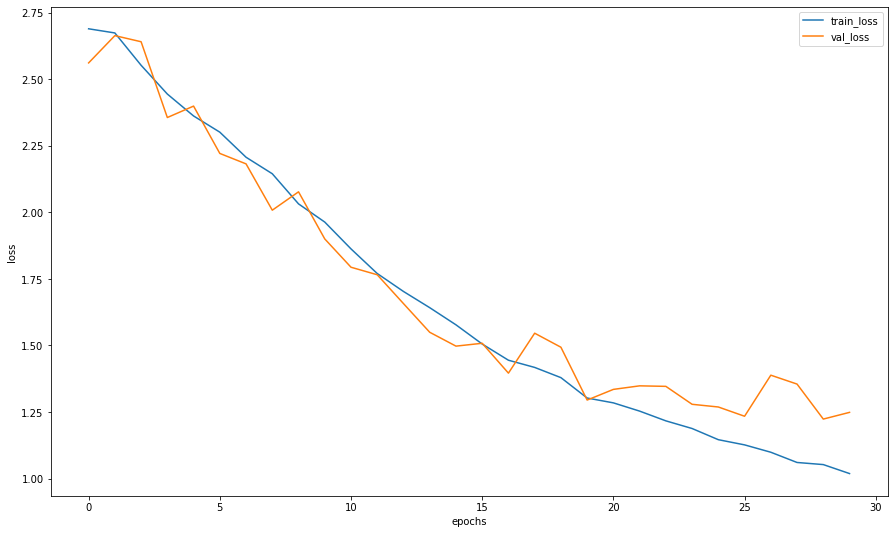

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

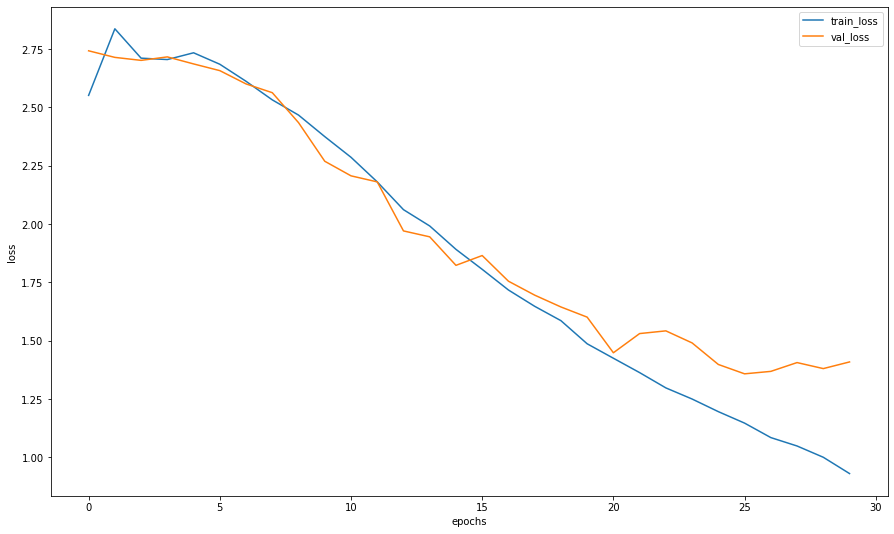

In [ ]:
loss, acc, val_loss, val_acc = zip(*resnet_34_fit)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

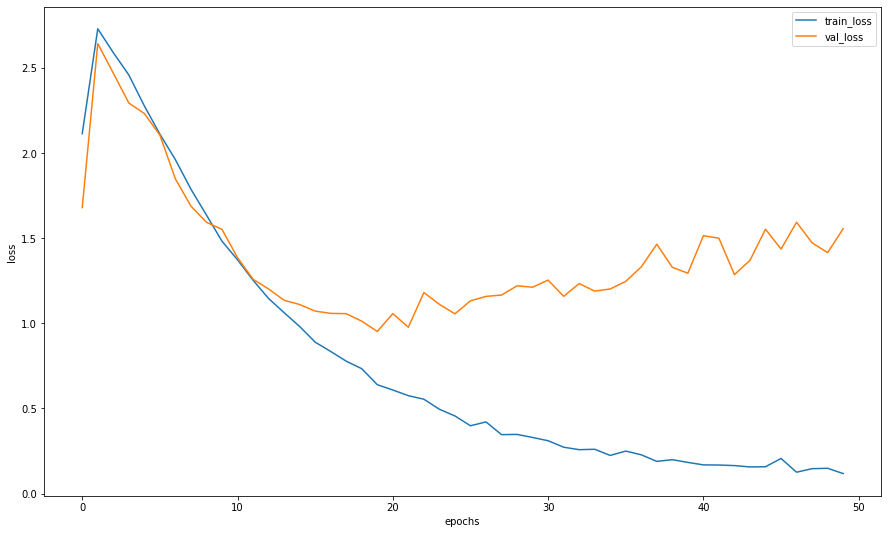

In [ ]:
loss, acc, val_loss, val_acc = zip(*resnet_34_256)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

###Предсказание одной картинки

#Предсказание

In [ ]:
test_files = []
for i in range(len(list_test_files)):
  for j in range(len(all_files)):
    if list_test_files.guid[i] == ntpath.basename(all_files[j]).split('.')[0] and list_test_files.guid[i] not in zero_f:
      test_files.append(all_files[j])
      

In [ ]:
filepath = '/content/gdrive/MyDrive/museum/model_resnet_34_30_256.pth'
model.load_state_dict(torch.load(filepath))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_dataset = MuseumDataset_ARG(test_files, labels=False, mode="test")

In [ ]:
#test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(model, test_loader) #res_net simple_cnn





In [ ]:
len(probs)

1117

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

#Сабмит

In [ ]:
list_test_sub = pd.read_csv("/content/gdrive/MyDrive/museum/sample_submission.csv")

In [ ]:
list_test_sub.head()

,guid,typology
0,a74014d7-3054-45bd-b284-ac117ccd2001,empty
1,783eab83-a48c-4950-996a-386fe93a3ccd,empty
2,8e7e2514-fab3-4287-be06-aae93c5397e0,empty
3,dc1964ce-9248-4fe7-9d4b-c110ac270f64,empty
4,1dd23c5e-bf5d-45b7-9894-07bfdf91ae80,empty


In [ ]:
typology = []
for i in list_train_files.typology:
  if i not in typology:
    typology.append(i)
#train_typology.typology

In [ ]:
print(len(list_test_sub) - len(test_filenames))

106


In [ ]:
out_file_sub = []
typology_sub = []
count = 0
for i in range(len(list_test_sub)):
  for j in range(len(test_filenames)):
    if list_test_sub.guid[i] == test_filenames[j].split('.')[0]:
          #guid_sub.append(list_test_sub.guid[i])
      typology_sub.append(preds[j])
      count += 1
      continue
  if count != i + 1:
    out_file_sub.append(list_test_sub.guid[i])

    typology_sub.append(typology[random.randrange(len(typology))])
 #   typology_sub.append('!')
    count += 1


In [ ]:
len(typology_sub)

1223

In [ ]:
typology_sub[3]

'живопись'

In [ ]:
import pandas as pd
mysubmit = pd.DataFrame(columns=['guid'])
#test_filenames = [path.name for path in test_dataset.files]
mysubmit['guid'] = list_test_sub.guid
mysubmit[f'typology'] = typology_sub
mysubmit.to_csv('/content/gdrive/MyDrive/museum/my_submission_13.csv', index=False)##


In [ ]:
_sub = pd.read_csv('/content/gdrive/MyDrive/museum/my_submission_5.csv')

In [ ]:
_sub.head()

,guid,typology
0,a74014d7-3054-45bd-b284-ac117ccd2001,предметы нумизматики
1,783eab83-a48c-4950-996a-386fe93a3ccd,фотографии и негативы
2,8e7e2514-fab3-4287-be06-aae93c5397e0,графика
3,dc1964ce-9248-4fe7-9d4b-c110ac270f64,живопись
4,1dd23c5e-bf5d-45b7-9894-07bfdf91ae80,предметы минералогической коллекции


In [ ]:
list_test_sub.head()

,guid,typology
0,a74014d7-3054-45bd-b284-ac117ccd2001,empty
1,783eab83-a48c-4950-996a-386fe93a3ccd,empty
2,8e7e2514-fab3-4287-be06-aae93c5397e0,empty
3,dc1964ce-9248-4fe7-9d4b-c110ac270f64,empty
4,1dd23c5e-bf5d-45b7-9894-07bfdf91ae80,empty


In [ ]:
typology = []
for i in train_typology.typology:
  if i not in typology:
    typology.append(i)
#train_typology.typology

In [ ]:
print(len(typology))

15


###DataSet

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
TRAIN_DIR = Path('/content/gdrive/MyDrive/museum/images/images/')

files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [ ]:
TRAIN_DIR = Path('/content/gdrive/MyDrive/museum/images/images/')
for i in range len
files = sorted(list(TRAIN_DIR.rglob(f'{train_typology.guid[i]}.jpg')))

In [ ]:
files

list

In [ ]:
test_files_ = []
train_files_ = []
for i in range(len(files)):
  for j in test_files.guid:
   if j == ntpath.basename(files[i]).split('.')[0]:
      test_files_.append(files[i])
  for x in train_typology.guid:
    if x == ntpath.basename(files[i]).split('.')[0]:
      train_files_.append(files[i])

In [ ]:
ntpath.basename(test_files_[0]).split('.')[0]
for i in range(len(test_files)):


'001e9cf1-b009-427c-abb6-6ed49688c746'

In [ ]:
len(train_typology.guid) == len(train_files_)

4735

In [ ]:
train_typology.typology()

TypeError: ignored

In [ ]:
ntpath.basename(files[0]).split('.')[0]

'00032b58-62d3-4724-b37b-b202dda6ce91'

In [ ]:
train_val_labels = [path.name for path in train_files_]

In [ ]:
import ntpath
ntpath.basename(files[0])

'00032b58-62d3-4724-b37b-b202dda6ce91.jpg'

In [ ]:
train_typology.guid[0]


'c84c547b-c5c5-45cf-9199-736df1301124'

In [ ]:
val_dataset = MuseumDataset(train_files_, mode='val')

#Main section

##DoDict_Config

In [ ]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

config = DotDict()
# with open('./dataset_stats.pickle', 'rb+') as f:
#     config.mean, config.std = pickle.load(f)
# Здесь мы задаем конечный размер картинки, которую выдает нам датасет и которая подается в модель.
# Если вы делаете предсказания не для соревнования, то поставьте здесь 250, тогда размер выходных масок сегментации будет
# 250х250, как и картинка, которая подавалась на вход. 
# Для соревнования размер 480х480
config.resize_min =480
config.resize_max = 480
config.crop_size = 480
config.pretrained = True
config.num_classes = 3#len(ChactunDataset.classes)
config.batch_size = 4
config.epochs = 15
config.lr = 1e-4
config.momentum = 0.9
config.num_workers = multiprocessing.cpu_count()
#экспериметы с добавлением каналов

config.sentinel1_bands = [98, 104, 99, 105, 109, 110, 115, 116]#ascending descending- VV HV mean, std
config.sentinel2_bands = sorted([0 + i for i in range(164, 217, 13)] + [0 + i for i in range(165, 218, 13)] + [0 + i for i in range(166, 219, 13)])#[216, 217, 218, 219]#NIR#[210, 211, 212]# sorted([2 + i for i in range(0, 221, 13)] + [3 + i for i in range(0, 221, 13)] + [4 + i for i in range(0, 221, 13)])#RGB
config.in_chanel = (len(config.sentinel1_bands) + len(config.sentinel2_bands) + 3)
config.pin_memory=True

##Utils

In [ ]:
def get_class(class_name):
    """returns the class type for a given class name. Expects a string of type `module.submodule.Class`"""
    module = class_name[: class_name.rindex(".")]
    cls = class_name[class_name.rindex(".") + 1:]
    return getattr(importlib.import_module(module), cls)


def current_ts():
    """returns current timestamp in secs"""
    return int(time())


def pil_loader(file, convert_to_grayscale=False):
    """open an image from disk"""
    with open(file, "rb") as f:
        if convert_to_grayscale:
            return np.asarray(Image.open(f).convert('L'))
        return np.asarray(Image.open(f))


def tiff_loader(file):
    """opens a tiff image from disk"""
    return tifffile.imread(file)


def image_loader(file_path, convert_to_grayscale=False):
    filename, file_extension = os.path.splitext(file_path)
    if file_extension in [".jpg", ".png", ".bmp"]:
        return pil_loader(file_path, convert_to_grayscale)
    elif file_extension in [".tif", ".tiff"]:
        return tiff_loader(file_path)
    else:
        raise ValueError(
            "Invalid image. It should be `.jpg, .png, .bmp, .tif, .tiff`"
        )


def image_invert(file_path, convert_to_grayscale=False):
    img = Image.open(file_path).convert('L')
    if convert_to_grayscale:
        img = ImageOps.invert(img)
    return np.asarray(img)


def stringify(obj):
    """stringify whatever object you have"""
    if isinstance(obj, list):
        response = ", ".join([stringify(o) for o in obj])
    elif isinstance(obj, dict):
        response = ", ".join([f"{k}:{stringify(v)}" for k, v in obj.items()])
    else:
        response = str(obj)

    return response


##Metric

###BaseMetric

In [ ]:
class BaseMetric:
    """Base class for implementing metrics """

    def __init__(self, device="cpu", **kwargs):
        self.device = device

    def calculate(self, y_true, y_pred):
        raise NotImplementedError("Please implement you metric calculation logic here.")


class RunningScore(object):
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device
        self.confusion_matrix = None

    def update(self, y_true, y_pred):
        """Updates stats on each batch"""
        self.confusion_matrix.update((y_pred, y_true))

    def reset(self):
        """Reset the confusion matrix"""
        self.confusion_matrix.reset()

    def get_computed(self):
        return self.confusion_matrix.compute().type(torch.DoubleTensor)

    def precision(self):
        raise NotImplementedError

    def accuracy(self):
        raise NotImplementedError

    def weights(self):
        raise NotImplementedError

    def recall(self):
        raise NotImplementedError

    def f1_score(self):
        precision = self.precision()
        recall = self.recall()
        micro = (
            2
            * precision["Precision Micro"]
            * recall["Recall Micro"]
            / (precision["Precision Micro"] + recall["Recall Micro"])
        )
        per_class = (
            2
            * precision["Precision per Class"]
            * recall["Recall per Class"]
            / (precision["Precision per Class"] + recall["Recall per Class"])
        )

        return {
            "F1_score Micro": float(micro),
            "F1_score Macro": np.mean(per_class),
            "F1_score Weighted": np.sum(self.weights() * per_class),
            "F1_score per Class": per_class.tolist(),
        }

    def iou(self):
        raise NotImplementedError

    def get_scores(self, metrics):
        """Returns the specified metrics"""
        result = []
        for metric in metrics:
            result.append(getattr(self, metric)())
        return result


class MultiClassRunningScore(RunningScore):
    """Calculates confusion matrix for multi-class data. This class contains metrics that are averaged over batches. """

    def __init__(self, num_classes, device):
        super().__init__(num_classes, device)
        self.confusion_matrix = confusion_matrix.ConfusionMatrix(
            num_classes=num_classes, device=device
        )

    def accuracy(self):
        cm = self.get_computed()
        accuracy = cm.diag().sum() / (cm.sum() + 1e-15)
        return {"Accuracy": accuracy}

    def weights(self):
        cm = self.get_computed()
        return (cm.sum(dim=1) / cm.sum()).numpy()

    def recall(self):
        cm = self.get_computed()
        micro = cm.diag().sum() / (cm.sum() + 1e-15)  # same as accuracy for multiclass
        macro = (cm.diag() / (cm.sum(dim=1) + 1e-15)).mean()
        weighted = (
            (cm.diag() / (cm.sum(dim=1) + 1e-15))
            * ((cm.sum(dim=1)) / (cm.sum() + 1e-15))
        ).sum()
        per_class = cm.diag() / (cm.sum(dim=1) + 1e-15)

        return {
            "Recall Micro": micro,
            "Recall Macro": macro,
            "Recall Weighted": weighted,
            "Recall per Class": per_class.numpy(),
        }

    def precision(self):
        cm = self.get_computed()
        micro = cm.diag().sum() / (cm.sum() + 1e-15)  # same as accuracy for multiclass
        macro = (cm.diag() / (cm.sum(dim=0) + 1e-15)).mean()
        weighted = (
            (cm.diag() / (cm.sum(dim=0) + 1e-15))
            * ((cm.sum(dim=1)) / (cm.sum() + 1e-15))
        ).sum()
        per_class = cm.diag() / (cm.sum(dim=0) + 1e-15)

        return {
            "Precision Micro": micro,
            "Precision Macro": macro,
            "Precision Weighted": weighted,
            "Precision per Class": per_class.numpy(),
        }

    def iou(self):
        cm = self.get_computed()
        iou = cm.diag() / (cm.sum(dim=1) + cm.sum(dim=0) - cm.diag() + 1e-15)

        return {"IOU": iou.tolist(), "mIOU": float(iou.mean())}


class MultiLabelRunningScore(RunningScore):
    """Calculates a confusion matrix for multi-labelled, multi-class data in addition to the """

    def __init__(self, num_classes, device):
        super().__init__(num_classes, device)
        self.confusion_matrix = MultiLabelConfusionMatrix(
            num_classes=self.num_classes, device=self.device,
        )

    def accuracy(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)

        accuracy = (tp_total + tn_total) / (tp_total + tn_total + fp_total + fn_total)
        accuracy_per_class = (tp + tn) / (tp + tn + fp + fn)

        return {"Accuracy": accuracy, "Accuracy per Class": accuracy_per_class}

    def precision(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)
        micro = tp_total / (tp_total + fp_total)
        per_class = tp / (tp + fp)
        macro = np.mean(per_class)
        weighted = np.sum(per_class * self.weights())
        return {
            "Precision Micro": float(micro),
            "Precision Macro": macro,
            "Precision Weighted": weighted,
            "Precision per Class": per_class,
        }

    def weights(self):
        tp, tn, fp, fn = self.get_outcomes()
        weights = (tp + fn) / self.get_samples()
        return weights

    def recall(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)
        micro = tp_total / (tp_total + fn_total)
        per_class = tp / (tp + fn)
        macro = np.mean(per_class)
        weighted = np.sum(per_class * self.weights())
        return {
            "Recall Micro": float(micro),
            "Recall Macro": macro,
            "Recall Weighted": weighted,
            "Recall per Class": per_class,
        }

    def get_outcomes(self, total=False):
        """
        Return true/false positives/negatives from the confusion matrix
        :param total: do we need to return per class or total
        """
        cm = self.get_computed()
        tp = cm[:, 1, 1]
        tn = cm[:, 0, 0]
        fp = cm[:, 0, 1]
        fn = cm[:, 1, 0]

        if total:  # sum it all if we need to calculate to totals
            tp, tn, fp, fn = tp.sum(), tn.sum(), fp.sum(), fn.sum()

        return tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()

    def count(self):
        tp, tn, fp, fn = self.get_outcomes(True)
        return tp + tn + fp + fn

    def get_samples(self):
        cm = self.confusion_matrix.compute().cpu().detach().numpy()
        return np.sum(cm[:, 1, 0]) + np.sum(cm[:, 1, 1])

    def iou(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)

        iou_per_class = tp / (tp + fp + fn)
        iou = tp_total / (tp_total + fp_total + fn_total)

        return {
            "IOU": float(iou),
            "IOU mean": np.mean(iou_per_class),
            "IOU per Class": iou_per_class.tolist(),
        }


class SegmentationRunningScore(RunningScore):
    """Calculates a metrics for semantic segmentation"""

    def __init__(self, num_classes, device):
        super().__init__(num_classes, device)
        self.iou_per_class = torch.zeros(num_classes, dtype=torch.float64).to(self.device)
        self.f1_score_per_class = torch.zeros(num_classes, dtype=torch.float64).to(self.device)
        self.pixel_accuracy_per_class = torch.zeros(num_classes, dtype=torch.float64).to(self.device)
        self.samples = 0

    def update(self, y_true, y_pred):
        """Updates metrics on each batch"""
        num_batches, num_labels, h, w = y_true.shape
        self.samples += num_batches
        for i in range(num_batches):
            for j in range(num_labels):
                intersection = (y_pred[i, j, :, :].unsqueeze(0) & y_true[i, j, :, :].unsqueeze(0)).float().sum(
                    (1, 2))
                union = (y_pred[i, j, :, :].unsqueeze(0) | y_true[i, j, :, :].unsqueeze(0)).float().sum(
                    (1, 2))
                self.iou_per_class[j] += ((intersection + 1e-15) / (union + 1e-15))[0]

    def reset(self):
        """Reset the metrics"""
        self.iou_per_class = torch.zeros(self.num_classes, dtype=torch.float64).to(self.device)
        self.f1_score_per_class = torch.zeros(self.num_classes, dtype=torch.float64).to(self.device)
        self.pixel_accuracy_per_class = torch.zeros(self.num_classes, dtype=torch.float64).to(self.device)
        self.samples = 0

    def iou(self):
        self.iou_per_class = self.iou_per_class / self.samples
        return {
            "IOU mean": float(self.iou_per_class.mean()),
            "IOU per Class": self.iou_per_class.tolist(),
        }


###AccuracyScore

In [ ]:
class AccuracyScore(BaseMetric):
    name = "accuracy"
    key = "accuracy"

    def __init__(self, **kwargs):
        BaseMetric.__init__(self, **kwargs)

    def calculate(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)


class AveragedScore(BaseMetric):
    def __init__(self, **kwargs):
        BaseMetric.__init__(self, **kwargs)
        self.method = None

    def calculate(self, y_true, y_pred):
        micro = self.method(y_true, y_pred, average="micro")
        macro = self.method(y_true, y_pred, average="macro")
        weighted = self.method(y_true, y_pred, average="weighted")

        return {"micro": micro, "macro": macro, "weighted": weighted}


class PrecisionScore(AveragedScore):
    name = "precision"
    key = "precision"

    def __init__(self, **kwargs):
        AveragedScore.__init__(self, **kwargs)
        self.method = precision_score


class RecallScore(AveragedScore):
    name = "recall"
    key = "recall"

    def __init__(self, **kwargs):
        AveragedScore.__init__(self, **kwargs)
        self.method = recall_score


class F1Score(AveragedScore):
    name = "f1 score"
    key = "f1_score"

    def __init__(self, **kwargs):
        AveragedScore.__init__(self, **kwargs)
        self.method = f1_score


##Config

In [ ]:
class Config(Munch):
    """ Config object used for automatic object creation from a dict.
    """

    def __init__(self, config):
        def convert(obj):
            """ Recursively convert a dict to Munch. (there is a Munch.from_dict method, but it's not python3 compatible)
            """
            if isinstance(obj, list):
                return [convert(element) for element in obj]
            if isinstance(obj, dict):
                return Munch({k: convert(v) for k, v in obj.items()})
            return obj

        config = convert(config)

        super().__init__(config)


class ObjectConfig(Schema):
    classname = fields.String(required=True, description="Class to instantiate.")
    config = fields.Dict(
        required=True, descripton="Configuration used for instantiation of the class."
    )


class RunConfig(Schema):
    """Top level configuration schema"""

    model = fields.Nested(ObjectConfig, missing=None, description="Model configuration")
    task = fields.Nested(ObjectConfig, required=True, description="Task configuration")


class Configurable(ABC):
    """ Base class for all configurable objects.
    """

    schema = None  # you need specify the schema of the class

    def __init__(self, config):
        if not self.schema:
            raise ValueError(f"You are missing a schema for {self.__class__}")
        self.config = Config(self.schema().load(config))


##DataSet

###BaseDatasetSchema

In [ ]:
class BaseDatasetSchema(Schema):
    batch_size = fields.Int(missing=64, description="Batch size", example=64)
    shuffle = fields.Bool(
        missing=True, description="Should shuffle dataset", example=False
    )
    num_workers = fields.Int(missing=4, description="Number of workers", example=4)
    pin_memory = fields.Bool(
        missing=False, description="Whether to use page-locked memory"
    )
    transforms = fields.List(
        fields.String, missing=None, description="Classes to run transformations.",
    )
    target_transforms = fields.List(
        fields.String, missing=None, description="Classes to run transformations.",
    )
    labels = fields.List(
        fields.String, missing=None, description="Labels for the dataset",
    )


class BaseModelSchema(Schema):
    num_classes = fields.Int(missing=2, description="Number of classes", example=2)
    use_cuda = fields.Bool(missing=True, description="Whether to use CUDA if possible")
    metrics = fields.List(
        fields.String,
        missing=["f1_score"],
        description="Metrics you want to calculate",
        example=["accuracy", "precision", "iou"],
        validate=validate.ContainsOnly(
            ["accuracy", "precision", "recall", "f1_score", "iou"]
        ),
    )
    weights = fields.List(
        fields.Float,
        missing=None,
        description="Classes weights you want to apply for the loss",
        example=[1.0, 2.3, 1.0],
    )


class BaseClassifierSchema(BaseModelSchema):
    learning_rate = fields.Float(
        missing=None, description="Learning rate used in training.", example=0.01
    )
    pretrained = fields.Bool(
        missing=True, description="Whether to use a pretrained network or not."
    )
    threshold = fields.Float(
        missing=0.5, description="Prediction threshold if needed", example=0.5
    )


class BaseSegmentationClassifierSchema(BaseClassifierSchema):
    metrics = fields.List(
        fields.String,
        missing=["iou"],
        description="Classes of metrics you want to calculate",
        example=["accuracy", "precision", "recall", "f1_score", "iou"],
    )


class BaseTransformsSchema(Schema):
    pass



###Shemas

In [ ]:
class MatDatasetSchema(BaseDatasetSchema):
    mat_file_path = fields.String(
        missing=None, description="mat file on disk", example="./data/dataset.mat",
    )
    mode = fields.String(
        missing='train', description="Which split to use, train or test.", example="train",
    )
    download = fields.Bool(
        missing=False, description="Whether to download the dataset", example=True
    )


class MultiClassClassificationDatasetSchema(BaseDatasetSchema):
    download = fields.Bool(
        missing=False, description="Whether to download the dataset", example=True
    )
    csv_file_path = fields.String(
        missing=None, description="CSV file on disk", example="./data/train.csv",
    )


class MultiLabelClassificationDatasetSchema(BaseDatasetSchema):
    root = fields.String(
        missing="/", description="Dataset path on disk", example="./data/BigEarthNet/"
    )

#Применяется эта схема
class SegmentationDatasetSchema(BaseDatasetSchema):
    root = fields.String(
        missing="/", description="Dataset path on disk", example="./data/BigEarthNet/"
    )
    csv_file_path = fields.String(
        missing=None, description="CSV file on disk", example="./data/train.csv",
    )


class BigEarthNetSchema(BaseDatasetSchema):
    csv_file_path = fields.String(
        missing=None, description="CSV file on disk", example="./data/train.csv"
    )
    lmdb_path = fields.String(required=True, description="Path to the lmdb storage")
    root = fields.String(
        required=True, description="Dataset path on disk", example="./data/BigEarthNet/"
    )
    import_to_lmdb = fields.Bool(
        missing=False, description="Should the data be moved to LMDB"
    )
    bands10_mean = fields.List(
        fields.Float,
        missing=[429.9430203, 614.21682446, 590.23569706],
        required=False,
        description="List of mean values for the 3 channels",
    )
    bands10_std = fields.List(
        fields.Float,
        missing=[572.41639287, 582.87945694, 675.88746967],
        required=False,
        description="List of std values for the 3 channels",
    )


###BaseTaskShema

In [ ]:
class BaseTaskShema(Schema):
    log = fields.Boolean(required=False, missing=True, description="Turn on logging")
    id = fields.String(
        required=False,
        description="Run name/ID",
        example="train_eurosat_123",
        missing=None,
    )


### PredictTaskSchema

In [ ]:
class PredictTaskSchema(BaseTaskShema):
    dir = fields.String(
        required=True,
        description="Directory with the image to perform prediction on",
        example="/tmp/test/",
    )
    model_path = fields.String(
        required=True,
        description="Path to the model",
        example="/tmp/model/checkpoint.pth.tar",
    )
    output_path = fields.String(
        missing="predictions.csv",
        description="File or folder path where the csv or plot predictions will be stored",
    )
    dataset_config = fields.Nested(
        missing=None,
        nested=ObjectConfig,
        description="Dataset type and configuration.",
    )
    batch_size = fields.Int(missing=64, description="Batch size", example=64)
    labels = fields.List(
        fields.String, missing=None, description="Labels needed to tag the predictions.",
    )
    transforms = fields.List(
        fields.String,
        missing=[
            "torchvision.transforms.ToPILImage",
            "torchvision.transforms.Resize",
            "torchvision.transforms.CenterCrop",
            "torchvision.transforms.ToTensor",
        ],
        description="Classes to run transformations.",
    )
    output_format = fields.String(
        missing="plot",
        description="Whether to output the predictions to csv or plots",
        validate=validate.OneOf(["plot", "csv", "image"]),
    )

###BaseDataSet

In [ ]:
class BaseDataset(Dataset, Configurable):

    schema = BaseDatasetSchema
    labels = None  # need to put the labels here
    name = None

    def __init__(self, config):
        Dataset.__init__(self)
        Configurable.__init__(self, config)

        # get dataloader parameters
        self.shuffle = self.config.shuffle
        self.batch_size = self.config.batch_size
        self.num_workers = self.config.num_workers
        self.pin_memory = self.config.pin_memory

        # get labels if provided in config and not set in class
        if not self.labels and self.config.labels:
            self.labels = self.config.labels

        # get the transformations to be applied for the image and for the target
        self.transform = self.load_transforms(self.config.transforms)
        self.target_transform = self.load_transforms(self.config.target_transforms)

    def __getitem__(self, index):
        """ Implement here what you want to return"""
        raise NotImplementedError(
            "Please implement the `__getittem__` method for your dataset"
        )

    def __len__(self):
        raise NotImplementedError(
            "Please implement the `__len__` method for your dataset"
        )

    def get_name(self):
        if self.name:
            return self.name
        else:
            return ""

    def prepare(self):
        """Implement if something needs to happen to the dataset after object creation"""
        return True

    def dataloader(self):
        return torch.utils.data.DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            # drop_last=True,
        )

    def get_labels(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `labels` method for your dataset"
        )

    def show_batch(self, size):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `show_batch` method for your dataset"
        )

    def show_samples(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `show_samples` method for your dataset"
        )

    def show_image(self, index):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `show_image` method for your dataset"
        )

    def data_distribution_table(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `data_distribution_table` method for your dataset"
        )

    def data_distribution_barchart(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `data_distribution_barchart` method for your dataset"
        )

    def load_transforms(self, class_names):
        """Loads transformation classes and make a composition of them"""
        return load_transforms(class_names, self.config)


###Новый ChactunDataset

In [ ]:
LABELS = ["aguada", "building", "platform"]

default_sentinel1_bands =  [
        97, #mean vv
        99, #std vv
        103, #mean vh
        105 #std vh
    ]
default_sentinel2_bands = [0] 



def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)


class ChactunDataset_new(Dataset):
    labels = LABELS
    classes = ['aguada', 'building', 'platform']
    
    def __init__(self, 
                root_folder, 
                is_train=True, 
                transform=None,
                target_transform=None):
                
        super().__init__()
        

        self.root = Path(root_folder)
        self.type = 'train' if is_train else 'test'
        self.transform = transform        
        self.target_transform = target_transform

        if is_train:
            self.masks_path = self.root / f'{self.type}_masks'
        self.lidar_path = self.root / f'lidar_{self.type}'
        

        self.ids = list(self.gather_complete_tile_ids())

    def gather_complete_tile_ids(self):
        if self.type == 'train':
            masks_ids = gather_tile_ids(self.masks_path)
        lidar_ids = gather_tile_ids(self.lidar_path)
        

        complete_ids = lidar_ids 
        all_ids = lidar_ids 
        if self.type == 'train':
            complete_ids &= masks_ids
            all_ids |= masks_ids

        if len(lidar_ids) < len(all_ids):
            print(f'Lidar images are missing ids: [{all_ids - lidar_ids}]')
        
        
        return complete_ids

    def load_lidar(self, id):
        pil_img = Image.open(self.lidar_path / f'tile_{id}_lidar.tif')
        return T.functional.to_tensor(pil_img)

    def dataloader(self):
        return torch.utils.data.DataLoader(
            self,
            batch_size=4,
            shuffle=False,
            num_workers=num_workers,#4
            pin_memory=True,
            # drop_last=True,#Раскоментить
        )
            #batch_size=self.batch_size,
            #shuffle=self.shuffle,
            #num_workers=self.num_workers,
            #pin_memory=self.pin_memory,
            # drop_last=True,
        

    

    def load_masks(self, id):
        if self.type == 'test':
            raise NotImplementedError('This dataset is meant for testing and doesn\'t have masks.')
        pil_masks = [np.array(Image.open(self.masks_path / f'tile_{id}_mask_{mask_class}.tif'))
                        for mask_class in self.classes]
        tensor_masks = torch.from_numpy(np.stack(pil_masks)).type(torch.float32) / 255
        # invert masks. Originally 1 = not present, 0 = present
        tensor_masks = 1 - tensor_masks
        return tensor_masks

    def __len__(self):
        return len(self.ids)

    def get_labels(self):
        return self.labels

    def __getitem__(self, i):
        id = self.ids[i]

        x = self.load_lidar(id)
        if self.type == 'train':
            y = self.load_masks(id)
        else:
            y = None

        if self.transform:
            x, y = self.transform(x, y)
        return x, y
    
    
    

class UpsampleSentinelToLidar(object):
    def __call__(self, images, target=None):
        lidar_size = images['lidar'].shape[1:]
        
        merged_image = torch.cat([img_channels for img_channels in images.values() 
                                    if img_channels is not None], dim=0)
        return merged_image, target

###MultiClassClassificationDataset

In [ ]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random



"""
The format of the multiclass classification dataset is:
image_path1,label1
image_path2,label2
...
"""


class MultiClassClassificationDataset(BaseDataset):
    schema = MultiClassClassificationDatasetSchema

    def __init__(self, config):
        # now call the constructor to validate the schema
        BaseDataset.__init__(self, config)

        # load the data
        self.data = self.load_dataset(self.config.csv_file_path)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # load image
        img = image_loader(self.data[index][0])
        # apply transformations
        if self.transform:
            img = self.transform(img)
        target = self.data[index][1]
        if self.target_transform:
            target = self.target_transform(self.data[index][1])
        return img, target

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return self.labels

    def data_distribution_table(self):
        df = pd.read_csv(self.config.csv_file_path, sep=",", names=["Image path", "Label"])
        label_count = df.groupby("Label").count().reset_index()
        label_count.columns = ['Label', 'Count']
        return label_count

    def data_distribution_barchart(self):
        label_count = self.data_distribution_table()
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.barplot(y="Label", x="Count", data=label_count, ax=ax)
        ax.set_title("Image distribution for {}".format(self.get_name()), fontsize=18)
        return fig

    def show_samples(self):
        df = pd.read_csv(self.config.csv_file_path, sep=",", names=["Image path", "Label"])
        return df.head(20)

    def show_image(self, index):
        label = self.labels[self[index][1]]
        fig = plt.figure(figsize=(8, 6))
        plt.title(f"Image with index {index} from the dataset {self.get_name()}, with label {label}\n",
                  fontsize=14)
        plt.axis('off')
        plt.imshow(self[index][0])
        return fig

    def show_batch(self, size):
        if size % 3:
            raise ValueError(
                "The provided size should be divided by 4!"
            )
        image_indices = random.sample(range(0, len(self.data)), size)
        figure_height = int(size / 3) * 4
        figure, ax = plt.subplots(int(size / 3), 3, figsize=(20, figure_height))
        figure.suptitle("Example images with labels from {}".format(self.get_name()), fontsize=32)
        for axes, image_index in zip(ax.flatten(), image_indices):
            axes.imshow(self[image_index][0])
            axes.set_title(self.labels[self[image_index][1]], fontsize=18)
            axes.set_xticks([])
            axes.set_yticks([])
        figure.tight_layout()
        #figure.subplots_adjust(top=1.0)
        return figure

    def load_dataset(self, file_path):
        if not self.labels:
            raise ValueError(
                "You need to provide the list of labels for the dataset"
            )
        data = []
        if file_path:
            with open(file_path, "r") as f:
                csv_reader = csv.reader(f)
                for index, row in enumerate(csv_reader):
                    path = row[0]
                    item = (path, self.labels.index(row[1]))
                    data.append(item)
        return data


###ChactunDataset

In [ ]:

default_sentinel1_bands =  [
        97, #mean vv
        99, #std vv
        103, #mean vh
        105, #std vh
    ]
default_sentinel2_bands = [] 



def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)


class ChactunDataset(Dataset):
    
    classes = ['aguada', 'building', 'platform']
    labels = classes
    def __init__(self, 
                root_folder, 
                is_train=True, 
                transform=None,
                sentinel1_bands=None,
                sentinel2_bands=None):
        super().__init__()
        if sentinel1_bands is None:
            sentinel1_bands = default_sentinel1_bands
        if sentinel2_bands is None:
            sentinel2_bands = default_sentinel2_bands
        self.sentinel1_bands = sentinel1_bands
        self.sentinel2_bands = sentinel2_bands

        self.root = Path(root_folder)
        self.type = 'train' if is_train else 'test'
        self.transform = transform
        self.num_bands = 3 + len(sentinel1_bands + sentinel2_bands)

        if is_train:
            self.masks_path = self.root / f'{self.type}_masks'
        self.lidar_path = self.root / f'lidar_{self.type}'
        self.sentinel1_path = self.root / f'Sentinel1_{self.type}'
        self.sentinel2_path = self.root / f'Sentinel2_{self.type}'

        self.ids = list(self.gather_complete_tile_ids())

    def gather_complete_tile_ids(self):
        if self.type == 'train':
            masks_ids = gather_tile_ids(self.masks_path)
        lidar_ids = gather_tile_ids(self.lidar_path)
        sentinel1_ids = gather_tile_ids(self.sentinel1_path)
        sentinel2_ids = gather_tile_ids(self.sentinel2_path)

        complete_ids = lidar_ids & sentinel1_ids & sentinel2_ids
        all_ids = lidar_ids | sentinel1_ids | sentinel2_ids
        if self.type == 'train':
            complete_ids &= masks_ids
            all_ids |= masks_ids

        if len(lidar_ids) < len(all_ids):
            print(f'Lidar images are missing ids: [{all_ids - lidar_ids}]')
        if len(sentinel1_ids) < len(all_ids):
            print(f'Sentinel1 images are missing ids: [{all_ids - sentinel1_ids}]')
        if len(sentinel2_ids) < len(all_ids):
            print(f'Sentinel2 images are missing ids: [{all_ids - sentinel2_ids}]')
        
        return complete_ids

    def load_lidar(self, id):
        pil_img = Image.open(self.lidar_path / f'tile_{id}_lidar.tif')
        return T.functional.to_tensor(pil_img)

    def load_sentinel1(self, id):
        if len(self.sentinel1_bands) == 0:
            return None
            
        img = gdal_array.LoadFile(str(self.sentinel1_path / f'tile_{id}_S1.tiff'))
        return torch.from_numpy(img)[self.sentinel1_bands]

    def load_sentinel2(self, id):
        if len(self.sentinel2_bands) == 0:
            return None

        img = gdal_array.LoadFile(str(self.sentinel2_path / f'tile_{id}_S2.tiff'))
        return torch.from_numpy(img)[self.sentinel2_bands]

    def load_masks(self, id):
        if self.type == 'test':
            raise NotImplementedError('This dataset is meant for testing and doesn\'t have masks.')
        pil_masks = [np.array(Image.open(self.masks_path / f'tile_{id}_mask_{mask_class}.tif'))
                        for mask_class in self.classes]
        tensor_masks = torch.from_numpy(np.stack(pil_masks)).type(torch.float32) / 255
        # invert masks. Originally 1 = not present, 0 = present
        tensor_masks = 1 - tensor_masks
        return tensor_masks

    def __len__(self):
        return len(self.ids)

    def dataloader(self):
        return torch.utils.data.DataLoader(
            self,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=config.num_workers,
            pin_memory=config.pin_memory,
            drop_last=True,
        )

    def get_labels(self):
        return self.labels

    def __getitem__(self, i):
        id = self.ids[i]

        x = {'lidar': self.load_lidar(id), 
             'sentinel1': self.load_sentinel1(id), 
             'sentinel2': self.load_sentinel2(id)}
        if self.type == 'train':
            y = self.load_masks(id)
        else:
            y = 0####none

        if self.transform:
            x, y = self.transform(x, y)
      
        return x, y


class UpsampleSentinelToLidar(object):
    def __call__(self, images, target=None):
        lidar_size = images['lidar'].shape[1:]

        if images['sentinel1'] is not None:
            images['sentinel1'] = T.functional.resize(images['sentinel1'], lidar_size,
                                                  interpolation=Image.BILINEAR)#
        if images['sentinel2'] is not None:
            images['sentinel2'] = T.functional.resize(images['sentinel2'], lidar_size,
                                                  interpolation=Image.BILINEAR)#
        
        merged_image = torch.cat([img_channels for img_channels in images.values() 
                                    if img_channels is not None], dim=0)
        return merged_image, target

### BaseTask

In [ ]:
class BaseTask(Configurable):
    def __init__(self, model, config):
        super().__init__(config)

        self.model = model

        # generate a task ID if not specified
        id = self.config.id
        if not id:
            id = str(self.generate_task_id())
        self.id = id

    @staticmethod
    def create_dataset(dataset_config):
        """ Builds the input dataset using the provided configuration. """

        classname, config = dataset_config.classname, dataset_config.config

        cls = get_class(classname)
        if not issubclass(cls, BaseDataset):
            raise ValueError("Data input class does not inherit from BaseInput.")

        dataset = cls(config)

        return dataset

    def generate_task_id(self):
        """Generates a task ID"""
        return current_ts()

    def run(self):
        """Runs the task."""
        raise NotImplementedError


##Transform

###Load_transforms

In [ ]:
TRANSFORMS_PARAMS = {
    "torchvision.transforms.Resize": 256,
    "torchvision.transforms.CenterCrop": 224,
}


def load_transforms(class_names, config):
    """Loads transformation classes and make a composition of them"""
    lst_transforms = []

    if not class_names:
        return None

    # check all transformation classes
    for name in class_names:
        cls = get_class(name)  # get class
        args = TRANSFORMS_PARAMS.get(name, None)  # get params, if specified
        if args:
            transfrm = cls(args)
        else:
            if getattr(cls, "configurables", None):
                kwargs = {}
                for key in cls.configurables:
                    kwargs[key] = getattr(config, key)
                transfrm = cls(**kwargs)
            else:
                transfrm = cls()

        lst_transforms.append(transfrm)

    # return as composition
    return transforms.Compose(lst_transforms)


class BaseTransforms(object):
    """Base class for implementing configurable transformations"""

    schema = BaseTransformsSchema

    configurables = None

    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, sample):
        raise NotImplementedError("Please implement the `__call__` method")


###NormalizeRGB

In [ ]:
class NormalizeRGB(BaseTransforms):

    configurables = ["bands10_mean", "bands10_std"]

    def __init__(self, *args, **kwargs):
        BaseTransforms.__init__(self, *args, **kwargs)

        self.bands10_mean = kwargs["bands10_mean"]
        self.bands10_std = kwargs["bands10_std"]

    def __call__(self, input, target=None):
        bands10, multihots = input

        for t, m, s in zip(bands10, self.bands10_mean, self.bands10_std):
            t.sub_(m).div_(s)

        return bands10, multihots


class ToTensorRGB(BaseTransforms):
    def __call__(self, input, target=None):
        bands10, multihots = input
        return torch.tensor(bands10), multihots


class NormalizeAllBands(BaseTransforms):

    configurables = ["bands10_mean", "bands10_std", "bands20_mean", "bands20_std"]

    def __init__(self, *args, **kwargs):
        BaseTransforms.__init__(self, *args, **kwargs)

        self.bands10_mean = kwargs["bands10_mean"]
        self.bands10_std = kwargs["bands10_std"]
        self.bands20_mean = kwargs["bands20_mean"]
        self.bands20_std = kwargs["bands20_std"]

    def __call__(self, input, target=None):
        bands10, bands20, multihots = input

        for t, m, s in zip(bands10, self.bands10_mean, self.bands10_std):
            t.sub_(m).div_(s)

        for t, m, s in zip(bands20, self.bands20_mean, self.bands20_std):
            t.sub_(m).div_(s)

        return bands10, bands20, multihots


class ToTensorAllBands(BaseTransforms):
    def __call__(self, input, target=None):
        bands10, bands20, multihots = input
        return torch.tensor(bands10), torch.tensor(bands20), multihots


###ResizeCenterCropFlipHVToTensor
    

In [ ]:
class ResizeCenterCropFlipHVToTensor(BaseTransforms):
    def __call__(self, sample):
        data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ])

        return data_transforms(sample)
class ResizeCenterCropToTensor(BaseTransforms):
    def __call__(self, sample):
        data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        return data_transforms(sample)

###Segmentation

In [ ]:
class MinMaxNormTransponse(BaseTransforms):
    def __call__(self, sample):
        return sample.transpose(2, 0, 1).astype("float32") / 255


class Transponse(BaseTransforms):
    def __call__(self, sample):
        return sample.transpose(2, 0, 1).astype("float32")


class MinMaxNorm(BaseTransforms):
    def __call__(self, sample):
        return sample.astype("float32") / 255

###Transformation

In [ ]:
def pad_if_smaller(img, size, fill=0):
    min_size = min(img.shape[1:])
    if min_size < size:
        ow, oh = img.size
        padh = size - oh if oh < size else 0
        padw = size - ow if ow < size else 0
        img = F.pad(img, (0, 0, padw, padh), fill=fill)
    return img


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomResize(object):
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        size = random.randint(self.min_size, self.max_size)
        image = transforms_F.resize(image, size)
        if target is not None:
            target = transforms_F.resize(target, size, interpolation=Image.NEAREST)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = transforms_F.hflip(image)
            if target is not None:
                target = transforms_F.hflip(target)
        return image, target


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = pad_if_smaller(image, self.size)
        target = pad_if_smaller(target, self.size, fill=255)
        crop_params = T.RandomCrop.get_params(image, (self.size, self.size))
        image = transforms_F.crop(image, *crop_params)
        if target is not None:
            target = transforms_F.crop(target, *crop_params)
        return image, target


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = transforms_F.center_crop(image, self.size)
        if target is not None:
            target = transforms_F.center_crop(target, self.size)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        if target is not None:
            target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = transforms_F.normalize(image, mean=self.mean, std=self.std)
        return image, target

##Визуализация

###BaseDetailedVisualization

In [ ]:
class BaseVisualization:
    """Base class for visualizations"""

    def __init__(self, cm, labels, file, **kwargs):
        """Get default params"""
        self.cm = cm
        self.labels = labels
        self.output_file = file

    def plot(self):
        raise NotImplementedError("Please implement the `plot` method.")


class BaseDetailedVisualization(BaseVisualization):
    """Base class for visualizations"""

    def __init__(self, y_true, y_pred, y_prob, labels, file, **kwargs):
        """Get default params"""
        super().__init__(None, labels, file, **kwargs)

        self.y_true = y_true
        self.y_pred = y_pred
        self.y_prob = y_prob

    def plot(self):
        raise NotImplementedError("Please implement the `plot` method.")


###ImageMaskPredictionVisualization

In [ ]:
class ImageMaskPredictionVisualization(BaseDetailedVisualization):
    def __init__(self, y_true, y_pred, y_prob, labels, file, **kwargs):###
        super().__init__(y_true, y_pred, y_prob, labels, file, **kwargs)
        self.image = kwargs.get("image")
        
    def plot(self):
        image = pil_loader(self.image)
        fig = self.plot_segmenation(image, self.y_prob, self.labels)
        fig.savefig(self.output_file, format="png")

    def plot_segmenation(self, img, probs, labels):
        """Display image and preditions from model"""

        # Show the image
        fig = plt.figure(figsize=(10, 10))

        # plot image
        plt.subplot(1, len(labels) + 1, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")
        
        

        # plot masks
        for i in range(len(probs)):
            plt.subplot(1, len(labels) + 1, i + 2)
            plt.imshow(probs[i])
            plt.title(labels[i])
            plt.axis("off")

        plt.tight_layout()

        return fig


def display_image_segmentation(image, y_true, y_pred, y_prob, labels, file):###
    viz = ImageMaskPredictionVisualization(
        y_true, y_pred, y_prob, labels, file, image=image
    )
    viz.plot()


def save_predicted_masks(y_pred, labels, base_filepath_name):
    # save predicted masks
    for i in range(len(labels)):
        mask = Image.fromarray(y_pred[i].astype(np.uint8)*255)
        mask = ImageOps.invert(mask)
        mask.save("{}_{}.png".format(base_filepath_name, labels[i]))


##Оптимизаторы

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, logits, targets):
        
        N = targets.size(0)
        preds = torch.sigmoid(logits)
        
        EPSILON = 1e-7
        
        # Flattening the final layer 
        preds_flat = preds.view(N,-1)
        targets_flat = targets.view(N, -1)
        
        intersection = (preds_flat * targets_flat).sum()
        union = (preds_flat + targets_flat).sum()
        
        loss = (2.0 * intersection + EPSILON) / (union + EPSILON)
        loss = 1 - loss / N
        return loss

##Модель

###BaseModel

определение batch_size и коэффициента разделения датасета

In [ ]:
#for i in range(1, 441):
 # for j in range(4, 34):
  #  if (1764 - i) % j == 0 and i % j == 0 and ((1 - (1764 - i) / 1764) < 0.35 and (1 - ((1764 - i) / 1764) > 0.1)):
  #    print(f'train: {(1764 - i)}, test: {i}, batch_size: {j} coefc: {round(1 - (1764 - i) / 1764, 3)}')


In [ ]:
class BaseModel(nn.Module, Configurable):

    schema = BaseModelSchema

    def __init__(self, config=None):
        Configurable.__init__(self, config)
        super(BaseModel, self).__init__()

        self.model = nn.Module()

        device_name = "cpu"
        if self.config.use_cuda and torch.cuda.is_available():
            device_name = "cuda"

        self.device = torch.device(device_name)

        self.metrics = self.config.metrics
        self.num_classes = self.config.num_classes
        self.running_metrics = RunningScore(self.num_classes, self.device)
        self.weights = self.config.weights

    def prepare(self):
        """Prepare the model before using it """

        # load loss, optimizer and lr scheduler
        self.criterion = self.load_criterion()
        self.optimizer = self.load_optimizer()
        self.lr_scheduler = self.load_lr_scheduler()

    def fit(
        self,
        dataset: BaseDataset,
        epochs: int = 100,
        model_directory: str = None,
        save_epochs: int = 10,
        iterations_log: int = 100,
        resume_model: str = None,
        val_dataset: BaseDataset = None,#BaseDataset = None
        run_id: str = None,
        **kwargs,
    ):
        logging.info("Starting training.")

        start_epoch = 0
        start = current_ts()

        # load the model if needs to resume training
        if resume_model:
            start_epoch, loss, start, run_id = self.load_model(
                resume_model, self.optimizer
            )

        # allocate device
        self.allocate_device()

        # start logger
        self.writer = SummaryWriter(os.path.join(model_directory, run_id))

        
        # get data loaders
        train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)#DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)#изменить при работе с DLS
        val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)#DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)#Noneизменить при работе с DLS
        if val_ds:#val_dataset:
            val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)#DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)#4изменить при работе с DLS

        for epoch in range(start_epoch, epochs):  # loop over the dataset multiple times
            loss = self.train_epoch(
                epoch, train_loader, self.optimizer, self.criterion, iterations_log
            )
            self.writer.add_scalar("Loss/train", loss, epoch + 1)
            if epoch % save_epochs == 0:
                self.save_model(
                    model_directory, epoch, self.optimizer, loss, start, run_id
                )
##Scheduler
            # adjust learning rate if needed
            if self.lr_scheduler:
               self.lr_scheduler.step()

            # evaluate against the train set
            train_loss = self.evaluate_model(
                train_loader,
                criterion=self.criterion,
                description="testing on train set",
            )
            self.log_metrics(
                self.running_metrics.get_scores(self.metrics),
                dataset.dataset.get_labels(),####dataset.
                "train",
                self.writer,
                epoch + 1,
            )
           #wandb.log()#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            self.running_metrics.reset()

            # evaluate against a validation set if there is one
            if val_loader:
                val_loss = self.evaluate_model(
                    val_loader,
                    criterion=self.criterion,
                    description="testing on validation set",
                )
                self.log_metrics(
                    self.running_metrics.get_scores(self.metrics),
                    dataset.dataset.get_labels(),####dataset.
                    "val",
                    self.writer,
                    epoch + 1,
                )
                self.writer.add_scalar("Loss/val", val_loss, epoch + 1)
                self.running_metrics.reset()
                ####
           
            

        self.writer.close()

        # save the model in the end
        self.save_model(model_directory, epochs, self.optimizer, loss, start, run_id)

        logging.info(f"finished training. training time: {current_ts() - start}")

    def train_epoch(self, epoch, dataloader, optimizer, criterion, iterations_log):
        start = current_ts()
        running_loss = 0.0
        total_loss = 0.0

        self.model.train()
        for i, data in enumerate(tqdm(dataloader, desc="training")):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # zero the parameter gradients
            if isinstance(optimizer, tuple):
                for opt in optimizer:
                    opt.zero_grad()
            else:
                optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self(inputs)

            # check if outputs is OrderedDict for segmentation
            if isinstance(outputs, collections.Mapping):
                outputs = outputs["out"]

            loss = criterion(
                outputs, labels if len(labels.shape) == 1 else labels.type(torch.float)
            )  # TODO: Check this converion OUT!!!
            loss.backward()

            # perform a single optimization step
            if isinstance(optimizer, tuple):
                for opt in optimizer:
                    opt.step()
            else:
                optimizer.step()

            # log statistics
            running_loss += loss.item() * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)

            if (
                i % iterations_log == iterations_log - 1
            ):  # print every iterations_log mini-batches
                logging.info(
                    f"[{epoch + 1}, {i + 1}], loss: {running_loss / iterations_log : .5f}"
                )
                #wandb.log({"loss": (running_loss / iterations_log)})
                running_loss = 0.0
        
        total_loss = total_loss / len(dataloader.dataset)
        #wandb.log({'loss': total_loss})
        logging.info(
            f"epoch: {epoch + 1}, time: {current_ts() - start}, loss: {total_loss: .5f}"
        )
        return total_loss

    def evaluate(
        self, dataset: BaseDataset = None, model_path: str = None,
    ):
        """
        Evaluate a model stored in a specified path against a given dataset

        :param dataset: the dataset to evaluate against
        :param model_path: the path to the model on disk
        :return:
        """
        # load the model
        self.load_model(model_path)

        # get test data loader
        
        dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)#4

        # evaluate model on data
        result = self.evaluate_model(dataloader, description="testing on test set")
        #wandb.log(result)####
        return result

    def evaluate_model(
        self, dataloader, criterion=None, description="testing on validation set",
    ):
        """
        Evaluates the current model against the specified dataloader for the specified metrics
        :param dataloader:
        :param metrics: list of metric keys to calculate
        :criterion: Criterion to calculate loss
        :description: What to show in the progress bar
        :return: tuple of (metrics, y_true, y_pred)
        """
        self.model.eval()

        # initialize loss if applicable
        total_loss = 0.0

        for inputs, outputs, labels in self.predict_output_per_batch(
            dataloader, description
        ):
            if criterion:
                batch_loss = criterion(outputs, labels)
                total_loss += batch_loss.item() * inputs.size(0)

            predicted_probs, predicted = self.get_predicted(outputs)

            if (
                len(labels.shape) == 1
            ):  # if it is multiclass, then we need one hot encoding for the predictions
                one_hot = torch.zeros(labels.size(0), self.num_classes)
                predicted = predicted.reshape(predicted.size(0))
                one_hot[torch.arange(labels.size(0)), predicted.type(torch.long)] = 1
                predicted = one_hot
                predicted = predicted.to(self.device)

            self.running_metrics.update(
                labels.type(torch.int64), predicted.type(torch.int64)
            )

        if criterion:
            total_loss = total_loss / len(dataloader.dataset)

        return total_loss

    def predict(
        self, dataset: BaseDataset = None, description="running prediction",
    ):
        """
        Predicts using a model against for a specified dataset

        :return: tuple of (y_true, y_pred, y_pred_probs)
        """
        # initialize counters
        y_true = []
        y_pred = []
        y_pred_probs = []
        dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)
        # predict
        for inputs, outputs, labels in self.predict_output_per_batch(
            dataloader, description            
        ):
        
            predicted_probs, predicted = self.get_predicted(outputs)
            y_pred_probs += list(predicted_probs.cpu().detach().numpy())
            y_pred += list(predicted.cpu().detach().numpy())
            y_true += list(labels.cpu().detach().numpy())

        return y_true, y_pred, y_pred_probs

   

    def predict_image(
        self,
        image=None,
        data_transforms=None,
        description="running prediction for single image",
    ):
        """
        Predicts using a model against for a specified image

        :return: tuple of (y_true, y_pred, y_pred_probs)
        """
        # load the image and apply transformations, if transforms in None convert only to Tensor
        self.model.eval()
        if data_transforms:
            image = data_transforms(image)
        else:
            data_transforms = transforms.Compose([transforms.ToTensor(),])
            image = data_transforms(image)
        # convert to batch of size 1
        inputs = image.unsqueeze(0).to(self.device)
        outputs = self(inputs)
        # check if outputs is OrderedDict for segmentation
        if isinstance(outputs, collections.Mapping):
            outputs = outputs["out"]

        predicted_probs, predicted = self.get_predicted(outputs)
        y_pred_probs = list(predicted_probs.cpu().detach().numpy())
        y_pred = list(predicted.cpu().detach().numpy())
        y_true = None

        return y_true, y_pred, y_pred_probs

    def predict_output_per_batch(self, dataloader, description):
        """Run predictions on a dataloader and return inputs, outputs, labels per batch"""

        # turn on eval mode
        self.model.eval()
        #dataset = test_ds# при тренировке
        #dataset = val_ds# при обучении
        #dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)#########
        # run predictions
        with torch.no_grad():
            for i, data in enumerate(tqdm(dataloader, desc=description)):
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self(inputs)

                # check if outputs is OrderedDict for segmentation
                if isinstance(outputs, collections.Mapping):
                    outputs = outputs["out"]

                yield inputs, outputs, labels
    def predict_output_npz(self, dataloader, description):
        """Run predictions on a dataloader and return inputs, outputs, labels per batch"""

        # turn on eval mode
        self.model.eval()

        # run predictions
        with torch.no_grad():
            for i, data in enumerate(tqdm(dataloader, desc=description)):
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self(inputs)

                # check if outputs is OrderedDict for segmentation
                if isinstance(outputs, collections.Mapping):
                    outputs = outputs["out"]

                yield inputs, outputs, labels

    def forward(self, *input, **kwargs):
        """
        Abstract method implementing the model. Extending classes should override this method.
        :return:  instance extending `nn.Module`
        """
        raise NotImplementedError

    def get_predicted(self, outputs, threshold=None):
        """Gets the output from the model and return the predictions
        :return: tuple in the format (probabilities, predicted classes/labels)
        """
        raise NotImplementedError("Please implement `get_predicted` for your model. ")

    def report(self, labels, dataset_name, running_metrics, **kwargs):
        """The report we want to generate for the model"""
        return ()

    def log_metrics(self, output, labels, tag="train", writer=None, epoch=0):
        """Log the calculated metrics"""
        calculated_metrics = output
        logging.info(stringify(calculated_metrics))
        if writer:
            for cm in calculated_metrics:
                for key in cm:
                    metric = cm[key]
                    if isinstance(metric, list) or isinstance(metric, np.ndarray):
                        for i, sub in enumerate(metric):
                            writer.add_scalar(f"{key}/{labels[i]}/{tag}", sub, epoch)
                    else:
                        writer.add_scalar(f"{key}/{tag}", metric, epoch)

    def allocate_device(self, opts=None):
        """
        Put the model on CPU or GPU
        :return:
        """
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        self.model = self.model.to(self.device)
        return self.model

    def save_model(self, model_directory, epoch, optimizer, loss, start, run_id):
        """
        Saves the model on disk
        :param model_directory:
        :return:
        """
        if not os.path.isdir(model_directory):
            os.makedirs(model_directory)

        if not os.path.isdir(os.path.join(model_directory, run_id)):
            os.makedirs(os.path.join(model_directory, run_id))

        timestamp = current_ts()
        checkpoint = os.path.join(
            model_directory, run_id, f"checkpoint_{timestamp}.pth.tar"
        )

        # create timestamped checkpoint
        torch.save(
            {
                "epoch": epoch + 1,
                "state_dict": self.model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss,
                "start": start,
                "id": run_id,
            },
            checkpoint,
        )

        # replace last checkpoint
        copyfile(checkpoint, os.path.join(model_directory, "checkpoint.pth.tar"))

    def extract_features(self, *input, **kwargs):
        """
        Abstract for trim the model to extract feature. Extending classes should override this method.
        """
        return self.model

    def load_model(self, file_path, optimizer=None):
        """Loads a model from a checkpoint"""
        if os.path.isfile(file_path):
            logging.info(f"Loading checkpoint {file_path}")
            checkpoint = torch.load(file_path)

            if "state_dict" in checkpoint:
                self.model.load_state_dict(checkpoint["state_dict"], strict=False)
                self.allocate_device()

                start_epoch = checkpoint["epoch"]
                loss = checkpoint["loss"]
                start = checkpoint["start"]
                run_id = checkpoint["id"]
            else:
                self.model.load_state_dict(checkpoint)
                self.allocate_device()

                start_epoch = 1
                loss = 0
                start = 0
                run_id = ""

            if optimizer:
                optimizer.load_state_dict(checkpoint["optimizer"])

            logging.info(f"Loaded checkpoint {file_path} at epoch {start_epoch}")
            return (start_epoch, loss, start, run_id)
        else:
            raise ValueError(f"No checkpoint found at {file_path}")

    def load_optimizer(self):
        """Load the optimizer"""
        raise NotImplementedError("Please implement `load_optimizer` for your model. ")

    def load_criterion(self):
        """Load the loss function"""
        raise NotImplementedError("Please implement `load_criterion` for your model. ")

    def load_lr_scheduler(self):
        raise NotImplementedError(
            "Please implement `load_lr_scheduler` for your model. "
        )

    def train_model(
        self,
        train_dataset: BaseDataset,
        epochs: int = 100,
        model_directory: str = None,
        save_epochs: int = 10,
        iterations_log: int = 100,
        resume_model: str = None,
        val_dataset: BaseDataset = None,
        run_id: str = None,
        **kwargs,
    ):
        return self.fit(
            dataset=train_dataset,
            epochs=epochs,
            model_directory=model_directory,
            save_epochs=save_epochs,
            iterations_log=iterations_log,
            resume_model=resume_model,
            run_id=run_id,
            **kwargs,
        )

    def train_and_evaluate_model(
        self,
        train_dataset: BaseDataset,
        epochs: int = 100,
        model_directory: str = None,
        save_epochs: int = 10,
        iterations_log: int = 100,
        resume_model: str = None,
        val_dataset: BaseDataset = None,
        run_id: str = None,
        **kwargs,
    ):
        return self.fit(
            dataset=train_data,
            epochs=epochs,
            model_directory=model_directory,
            save_epochs=save_epochs,
            iterations_log=iterations_log,
            resume_model=resume_model,
            val_dataset=val_dataset,
            run_id=run_id,
            **kwargs,
        )

###ImageFolderDataset

In [ ]:
def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)

class ImageFolderDataset(BaseDataset):
    def __init__(self, root, labels, transforms, batch_size):
        BaseDataset.__init__(self, {})

        self.root = root
        self.labels = labels
        self.transform = transforms
        #self.transform = self.load_transforms(transforms)
        self.shuffle = False
        self.batch_size = batch_size

        self.data = []
        self.fnames = []
        self.ids = []
        #self.lidar_path = self.root / f'lidar_'###
        #self.ids = list(gather_tile_ids(fnamesh))###

        def gather_complete_tile_ids(self):###
            lidar_ids = gather_tile_ids(self.lidar_path)###

        dir = os.path.expanduser(self.root)
        for root, _, fnames in sorted(os.walk(dir)):
            for fname in sorted(fnames):
                self.data.append(os.path.join(root, fname))
                self.fnames.append(fname)
                self.ids.append(int(fname.split('_')[1]))
                
    def __getitem__(self, index):
        img = self.data[index]
        return (
            #self.transform(image_loader(img)),
            self.transform(image_loader(img)),
            0,
        )  # returning `0` because we have no target

    def __len__(self):
        return len(self.data)


class PredictTask(BaseTask):
    schema = PredictTaskSchema

    def __init__(self, model: BaseModel, config):
        super().__init__(model, config)

        self.dir = self.config.dir
        self.output_path = self.config.output_path
        self.output_format = self.config.output_format

    def run(self):
        """Do something awesome here"""


###BaseSegmentationClassifier

Здесь мы меняем оптимизаторы, функцию потерь, scheduler, эксперименты проводились в конфигурациях:
1. optim.Adam + nn.MSELoss;#Базовые настройки 25 epoch + randomflip 
> IOU_Mean:0.767 iou_aguada: 0.979, iou_building: 0.661, iou_platform: 0.666
2. optim.AdamW + Focal Loss;#Не заработало
3. optim.AdamW + Focal Loss + scheduler#Не заработало
4. optim.SGD + nn.MSELoss#Работает  15 epoch + randomflip
> IOU: 0.622284 IOU-a: 0.963415 IOU-p: 0.480418 IOU-b: 0.423019
5. optim.Adam + nn.MSELoss;#Базовые настройки 30 epoch + randomflip + 0.404treshold
> IOU_Mean:0.780 iou_aguada: 0.984, iou_building: 0.681, iou_platform: 0.677






In [ ]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


class BaseSegmentationClassifier(BaseModel):

    schema = BaseSegmentationClassifierSchema

    def __init__(self, config):
        super().__init__(config)

        self.running_metrics = SegmentationRunningScore(self.num_classes, self.device)

    def get_predicted(self, outputs, threshold=None):
        predicted_probs = torch.tanh(outputs)
        predicted = (predicted_probs >= self.config.threshold).type(
            predicted_probs.dtype
        )
        return predicted_probs, predicted

    def load_optimizer(self):
        """Load the optimizer"""
        return optim.AdamW(self.model.parameters())#optim.SGD(self.model.parameters(), lr=self.config.learning_rate, momentum=0.9)#optim.Adam(self.model.parameters())#optim.SGD(self.model.parameters(), lr=self.config.learning_rate, momentum=0.9)#optim.Adam(self.model.parameters())#, lr=self.config.learning_rate, momentum=0.9)#optim.AdamW([dict(params=self.model.parameters(), lr=self.config.learning_rate), ])# 
        #optim.SGD(self.model.parameters(), lrself.config.learning_rate, momentum=0.9)#optim.AdamW(self.model.parameters(), lr=0.0001, eps=1e-08, weight_decay=0.05, amsgrad=False)####Попродовать optimizer

    def load_criterion(self):
        """Load the loss function"""
        return nn.BCELoss()#nn.MSELoss(reduction="mean")#nn.BCELoss(reduction="mean")#nn.MSELoss(reduction="mean")###Попродовать поменять лосс функц nn.BCELoss()

    def load_lr_scheduler(self):
        return optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[30,60], gamma=0.8)#None#optim.lr_scheduler.OneCycleLR(self.optimizer, self.config.learning_rate, epochs=epochs)
        #optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min'),#None#optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[30,60], gamma=0.8)#None###Попродовать поменять sceduler ReduceLROnPlateau
        

###DeeplabV3

In [ ]:
in_chanel = config.in_chanel
class DeepLabV3(BaseSegmentationClassifier):
    def __init__(self, config):
        BaseSegmentationClassifier.__init__(self, config)

        self.model = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True
        )
        # change first layer to work with different number of classes
        
        self.model.backbone.conv1 = nn.Conv2d(in_chanel , 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)#меняем колличество входных каналов
        #self.model.backbone.conv1 = nn.Conv2d(in_chanel , 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        # change last layer to work with different number of classes
        self.model.classifier[4] = nn.Conv2d(256, self.config.num_classes, 1)

    #def forward(self, x):
        #return self.model(x)
    def forward(self, X):
        return torch.sigmoid(self.model(X)['out'])

#Loader data

###DLS_Dataloader

In [ ]:
def get_transofrms(h_flip_prob, resize_min, resize_max, crop_size, mean, std):
    train_transform = Compose([        
        UpsampleSentinelToLidar(),
        RandomHorizontalFlip(0.5),
        #NormalizeAllBands(0.485, 0.456, 0.406)
        RandomResize(config.resize_min, config.resize_max),##
        RandomCrop(crop_size)#
        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = Compose([
        UpsampleSentinelToLidar(),
        #RandomResize(config.resize_min, config.resize_max),##
        #RandomCrop(crop_size)##
        ###
    ])

    return train_transform, test_transform

def get_dataset(config, root='./data', val_size=0.2495):
    train_transform, test_transform = get_transofrms(
        config.h_flip_prob,
        config.resize_min,
        config.resize_max,
        config.crop_size,
        config.mean,
        config.std
    )

    # У нас есть два датасета, один с ответами, а другой без.
    # Первый датасет мы поделим на train часть и валидационную часть.
    ds = ChactunDataset(root, is_train=True, transform=train_transform,
                        sentinel1_bands=config.sentinel1_bands,
                        sentinel2_bands=config.sentinel2_bands)
    train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])

    test_ds = ChactunDataset('/content/gdrive/MyDrive/test', is_train=False, transform=test_transform,
                             sentinel1_bands=config.sentinel1_bands,
                             sentinel2_bands=config.sentinel2_bands)

    return train_ds, val_ds, test_ds, ds

In [ ]:
from torch.utils.data import DataLoader
random.seed(42) #Чтобы можно было доучивать сеть после сброса среды
train_ds, val_ds, test_ds, datase = get_dataset(config, '/content/gdrive/MyDrive/train')

train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)
print(len(train_dl), len(val_dl), len(test_dl))


331 110 83


#Обучение модели

###Загрузка параметров модели

In [ ]:
epochs = config.epochs
model_directory = "/content/gdrive/MyDrive/model_404"
model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}#lr 0.001 попробовать 0.45
model = DeepLabV3(model_config)

model.prepare()
#wandb.watch(model, log_freq=100)#

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


###Стар обучения

In [ ]:
model.train_model(
    train_dataset=train_ds,
    epochs=epochs,
    model_directory=model_directory,
    val_dataset=val_ds,
    run_id='05_07_21',
    resume_model=None#model_path#для продолжения обучения
     
)

2021-07-05 06:22:33,652 INFO Starting training.
training:   0%|          | 0/331 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it wi

KeyboardInterrupt: ignored

###Продолжение обучения

In [ ]:
config.epochs += 11#+5 эпох 
#config.thresh = 0.5
#print(epochs)
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"#Путь к сохраненной модели


In [ ]:
config.epochs = 70#+5 эпох 
config.thresh = 0.5
#print(epochs)6
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"#Путь к сохране6нной модели


In [ ]:
model.train_model(
    train_dataset=train_ds,
    epochs=config.epochs,
    model_directory=model_directory,
    val_dataset=val_ds,
    run_id='29_06_21',
    resume_model=model_path#для продолжения обучения
     
)

2021-06-30 06:52:11,611 INFO Starting training.
2021-06-30 06:52:11,616 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-06-30 06:52:12,742 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 32
training:   0%|          | 0/331 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/

In [ ]:
model.train_model(
    train_dataset=train_ds,
    epochs=config.epochs,
    model_directory=model_directory,
    val_dataset=val_ds,
    run_id='30_06_21',
    resume_model=model_path#для продолжения обучения
     
)

2021-06-30 12:58:52,978 INFO Starting training.
2021-06-30 12:58:52,980 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-06-30 12:58:54,259 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 43
training:   0%|          | 0/331 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
training: 100%|██████████| 331/331 [26:28<00:00,  4.80s/it]
2021-06-30 13:25:22,348 INFO epoch: 44, time: 1588, loss:  0.01664
testing on train set: 100%|██████████| 331/331 [03:20<00:00,  1.65it/s]
2021-06-30 13:28:43,150 INFO IOU mean:0.7717106015753403, IOU per Class:0.9732125119077185, 0.6658178176379164, 0.6761014751803863
testing on validation set: 100%|██████████| 110/110 [01:09<00:00,  1.59it/s

In [ ]:
model.train_model(
    train_dataset=train_ds,
    epochs=config.epochs,
    model_directory=model_directory,
    val_dataset=val_ds,
    run_id='30_06_21',
    resume_model=model_path#для продолжения обучения
     
)

2021-06-30 18:22:54,329 INFO Starting training.
2021-06-30 18:22:54,333 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-06-30 18:22:55,614 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 54
training:   0%|          | 0/331 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
training: 100%|██████████| 331/331 [26:32<00:00,  4.81s/it]
2021-06-30 18:49:28,572 INFO epoch: 55, time: 1593, loss:  0.01448
testing on train set: 100%|██████████| 331/331 [03:27<00:00,  1.59it/s]
2021-06-30 18:52:56,353 INFO IOU mean:0.7900376489655839, IOU per Class:0.9819995408098345, 0.673132489642179, 0.7149809164447384
testing on validation set: 100%|██████████| 110/110 [01:10<00:00,  1.57it/s]

#Проверка результатов на валидационной части датасета

###Загрузка параметров модели

In [ ]:
#config.thresh = 0.404
model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": config.thresh}#подбор trherloda
model = DeepLabV3(model_config)
model.prepare()
#model_path = "/content/gdrive/MyDrive/experiments/10_06_1_checkpoint.pth.tar"##путь к весам
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"##путь к весам
#wandb.watch(model, log_freq=100)#

###Старт анализа

In [ ]:
model.evaluate(dataset=val_ds, model_path=model_path)
model.running_metrics.get_scores(["iou"])

#Предсказание

###Загрузка параметров

In [ ]:
#model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}
model = DeepLabV3(model_config)
model.prepare()

###Загрузка модели

In [ ]:
# load the model
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"
model.load_model(model_path)

2021-07-01 07:12:53,119 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-07-01 07:12:53,970 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 71


(71, 0.011641348977685763, 1624966543, '29_06_21')

###Старт предсказания

In [ ]:
# Run predictions
y_true, y_pred, y_prob = model.predict(dataset=test_ds)

running prediction:   0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:323: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
running prediction: 100

###Визуализация одной маски

(-0.5, 479.5, 479.5, -0.5)

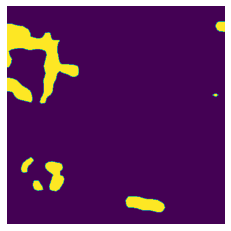

In [ ]:
%matplotlib inline 
from matplotlib import pyplot as plt

masks = Image.fromarray((y_pred[58][1] * 255).astype(np.uint8)) #Выгрузка была здесь
#masks = 255 - (y_pred[12][3] * 255).astype(np.byte) 
#masks = Image.fromarray((y_prob[12][0] * 255).astype(np.uint8)) #Выгрузка была здесь
plt.imshow(masks)

plt.axis('off')


#Вывод данных

###Сохраняем маски на диск

In [ ]:
count_operation = 0
for j in range(len(test_ds)):
    for i in range(len(test_ds.labels)):        
        tile_id = test_ds.ids[j]
        class_name = test_ds.labels[i].lower()
        masks = Image.fromarray((y_pred[j][i] * 255).astype(np.uint8))#вывод 
        masks = ImageOps.invert(masks)          #Отправить Без инвертирования для aguarda попробовать инвертировать building and platform
        masks.save(f'/content/gdrive/MyDrive/model_2/pred/tile_{tile_id}_mask_{class_name}.tif')#png
        count_operation += 1
print(f'Сохранено {count_operation} изображений. Операция завершена {datetime.now()}')#Контроль объема исходящих данных    

###Конвертация в .npz

In [ ]:
def convert_image(img_path):
    img=Image.open(img_path)
    return sparse.csr_matrix(ImageOps.invert(img),dtype=bool)
count_operation = 0
for file in os.listdir('/content/gdrive/MyDrive/model_2/pred/'):
    fname = os.path.join('/content/gdrive/MyDrive/model_2/pred_npz/', file)
    fname_tif = os.path.join('/content/gdrive/MyDrive/model_2/pred/', file)
    sparse.save_npz(os.path.splitext(fname)[0]+'.npz', convert_image(fname_tif), compressed=True)
    count_operation += 1
print(f'Сконвертировано {count_operation} изображений. Операция завершена {datetime.now()}')#Контроль объема исходящих данных

###ZIP

In [ ]:
!zip ./my_preds_last.zip /content/gdrive/MyDrive/model_2/pred_npz/*

  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1765_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1765_mask_building.npz (deflated 56%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1765_mask_platform.npz (deflated 29%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1766_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1766_mask_building.npz (deflated 25%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1766_mask_platform.npz (deflated 37%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1767_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1767_mask_building.npz (deflated 10%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1767_mask_platform.npz (deflated 12%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1768_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1768_mask_building.npz 